## Competition documentation

[Linking Writing Processes to Writing Quality](https://www.kaggle.com/competitions/linking-writing-processes-to-writing-quality)

## Imports

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from pathlib import Path
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
SEED=7

## Reading data

In [2]:
path = Path('../input/linking-writing-processes-to-writing-quality')
path_keystroke_measures = Path('../input/keystroke-measures')

In [3]:
os.listdir(path)

['sample_submission.csv',
 'test_logs.csv',
 'train_scores.csv',
 'train_logs.csv']

In [4]:
test_logs = pd.read_csv(path/'test_logs.csv')
train_scores = pd.read_csv(path/'train_scores.csv')

with open(path_keystroke_measures/'train_logs.pkl', 'rb') as file:
    train_logs = pd.read_pickle(file)

DEBUG = False   
    
if DEBUG:
    num_essays = 100
    train_logs = train_logs[train_logs.id.isin(train_logs.id.unique()[:num_essays])]
    train_scores = train_scores[train_scores.id.isin(train_logs.id.unique()[:num_essays])]
    print(f"Debug mode activated. Utilizing {num_essays} essays from train_logs and train_scores.")
else:
    print("Debug mode has been deactivated. The whole dataset of train_logs and train_scores will be utilized:",
          f"{train_logs.id.nunique()} essays.")

Debug mode has been deactivated. The whole dataset of train_logs and train_scores will be utilized: 2471 essays.


## EDA

### test_logs

`test_logs` includes data for 3 essays. It is meant to serve as an example to illustrate the format.

The real `test_logs` will replace it when submissions are scored, according to the competition documentation. 

### **score** - target variable

The average score is 3.71. The median is 4.0
There are 12 possible values for essay score: [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0] 




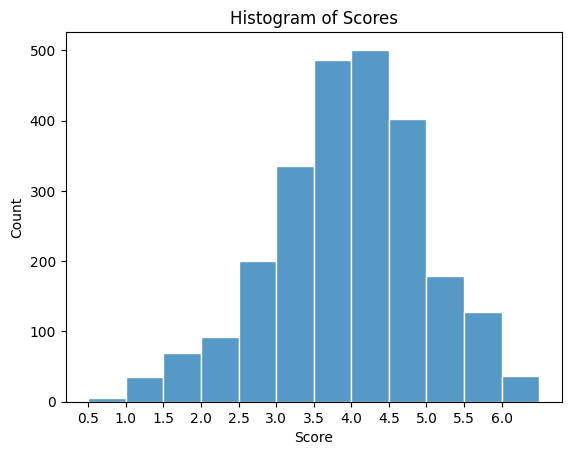

The score 0.5 is represented by only five data points, all of which register as zero.



In [5]:
print(f'The average score is {train_scores.score.mean().round(2)}. The median is {train_scores.score.median()}')

sns.histplot(train_scores.score, bins=12, edgecolor='white', binwidth=0.4999)
xticks = [0.5 * i for i in range(1, 13)]
plt.xticks(xticks)
plt.xlabel('Score');
plt.ylabel('Count');
plt.title('Histogram of Scores')

print(f'There are {train_scores.score.nunique()} possible values for essay score:', 
      sorted(train_scores.score.unique()), '\n\n')

# train_scores.score = train_scores.score*2 - 1

# train_scores.score = pd.Categorical(train_scores.score, sorted(train_scores.score.unique()), ordered=True)
plt.show()
print('The score 0.5 is represented by only five data points, all of which register as zero.\n')
# print('Changing type to Categorical:\n', train_scores.score.unique())

### train_logs

In [6]:
train_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,num_events,total_time_mins,total_action_time_mins,mean_action_time_ms,chars_product,chars_per_min_product,chars_process,chars_per_min_process,words_per_min_product,words_per_min_process,sentences_per_min_process,sentences_per_min_product,paragraphs_per_min_process,num_pauses,pauses_per_min,pause_time_proportion_perc,mean_pause_length,mean_pause_length_btw_paragraphs,mean_pause_length_btw_sentences,mean_pause_length_btw_words,mean_pause_length_w_in_words,deletions,deletions_per_min,mean_length_deletions,distant_deletions,deletions_proportion_perc,imm_deletions,distant_deletion_ratio,product_process_ratio,p_bursts,r_bursts,p_bursts_per_min,r_bursts_per_min,mean_p_bursts_chars,mean_r_bursts_chars,p_bursts_proportion_perc,r_bursts_proportion_perc,std_chars_interval
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0,2557,30.0,5.0,116.2,1528.0,50.9,2017.0,67.2,8.5,11.6,0.7,21.8,0.1,124.0,4.1,65.7,9537.1,19790.5,8271.9,1835.9,780.7,96.0,3.2,4.3,3.0,8.5,93.0,0.0,0.8,16.0,7.0,0.5,0.2,28.1,25.9,4.5,2.0,5.2
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0,2557,30.0,5.0,116.2,1528.0,50.9,2017.0,67.2,8.5,11.6,0.7,21.8,0.1,124.0,4.1,65.7,9537.1,19790.5,8271.9,1835.9,780.7,96.0,3.2,4.3,3.0,8.5,93.0,0.0,0.8,16.0,7.0,0.5,0.2,28.1,25.9,4.5,2.0,5.2
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0,2557,30.0,5.0,116.2,1528.0,50.9,2017.0,67.2,8.5,11.6,0.7,21.8,0.1,124.0,4.1,65.7,9537.1,19790.5,8271.9,1835.9,780.7,96.0,3.2,4.3,3.0,8.5,93.0,0.0,0.8,16.0,7.0,0.5,0.2,28.1,25.9,4.5,2.0,5.2
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1,2557,30.0,5.0,116.2,1528.0,50.9,2017.0,67.2,8.5,11.6,0.7,21.8,0.1,124.0,4.1,65.7,9537.1,19790.5,8271.9,1835.9,780.7,96.0,3.2,4.3,3.0,8.5,93.0,0.0,0.8,16.0,7.0,0.5,0.2,28.1,25.9,4.5,2.0,5.2
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1,2557,30.0,5.0,116.2,1528.0,50.9,2017.0,67.2,8.5,11.6,0.7,21.8,0.1,124.0,4.1,65.7,9537.1,19790.5,8271.9,1835.9,780.7,96.0,3.2,4.3,3.0,8.5,93.0,0.0,0.8,16.0,7.0,0.5,0.2,28.1,25.9,4.5,2.0,5.2


#### train_logs --> simplified_train_logs

Ultimately, we will retain only a single row for each essay:

In [7]:
redundant_vars = ['num_pauses', 'chars_process', 'chars_product']
train_logs.drop(redundant_vars, axis=1, inplace=True)

original_cols_ex_id = ['event_id', 'down_time', 'up_time', 'action_time', 'activity',
                       'down_event', 'up_event', 'text_change', 'cursor_position', 'word_count']

simplified_train_logs = train_logs.drop(original_cols_ex_id, axis=1)

simplified_train_logs.drop_duplicates(inplace=True)
simplified_train_logs.reset_index(drop=True, inplace=True)

print("\nNumber of features in train_logs vs simplified_train_logs:",len(train_logs.columns), 'vs', len(simplified_train_logs.columns), '\n')
print("Number of rows in train_logs vs simplified_train_logs:",train_logs.shape[0], 'vs', simplified_train_logs.shape[0], '\n')
simplified_train_logs.head()


Number of features in train_logs vs simplified_train_logs: 46 vs 36 

Number of rows in train_logs vs simplified_train_logs: 8405898 vs 2471 



,id,num_events,total_time_mins,total_action_time_mins,mean_action_time_ms,chars_per_min_product,chars_per_min_process,words_per_min_product,words_per_min_process,sentences_per_min_process,sentences_per_min_product,paragraphs_per_min_process,pauses_per_min,pause_time_proportion_perc,mean_pause_length,mean_pause_length_btw_paragraphs,mean_pause_length_btw_sentences,mean_pause_length_btw_words,mean_pause_length_w_in_words,deletions,deletions_per_min,mean_length_deletions,distant_deletions,deletions_proportion_perc,imm_deletions,distant_deletion_ratio,product_process_ratio,p_bursts,r_bursts,p_bursts_per_min,r_bursts_per_min,mean_p_bursts_chars,mean_r_bursts_chars,p_bursts_proportion_perc,r_bursts_proportion_perc,std_chars_interval
0,001519c8,2557,30.0,5.0,116.2,50.9,67.2,8.5,11.6,0.7,21.8,0.1,4.1,65.7,9537.1,19790.5,8271.9,1835.9,780.7,96.0,3.2,4.3,3.0,8.5,93.0,0.0,0.8,16.0,7.0,0.5,0.2,28.1,25.9,4.5,2.0,5.2
1,0022f953,2454,29.8,4.6,112.2,56.2,65.1,10.7,12.4,0.6,17.9,0.2,2.7,65.8,14521.8,NaN,3197.7,1207.0,784.3,82.0,2.8,3.2,8.0,0.0,74.0,0.1,0.9,8.0,20.0,0.3,0.7,34.9,37.2,3.1,8.3,8.3
2,0042269b,4136,29.5,7.0,101.8,87.7,119.4,13.7,18.6,0.7,20.9,0.6,2.6,62.8,14430.7,4804.0,3315.3,1637.2,492.0,97.0,3.3,4.5,5.0,0.0,92.0,0.1,0.7,17.0,47.0,0.6,1.6,39.9,39.4,4.1,12.1,3.7
3,0059420b,1556,23.4,3.2,121.8,49.3,56.3,8.8,10.4,0.6,13.0,0.1,3.7,54.7,8828.4,61128.7,14315.4,2824.9,1199.7,66.0,2.8,2.3,1.0,0.0,65.0,0.0,0.9,4.0,3.0,0.2,0.1,27.5,28.7,3.4,2.1,2.8
4,0075873a,2531,27.7,5.2,123.9,51.4,70.1,9.1,12.2,0.9,24.7,0.4,3.2,62.9,11880.3,37640.0,12462.1,2293.4,1212.0,58.0,2.1,8.9,8.0,0.0,50.0,0.1,0.7,16.0,8.0,0.6,0.3,47.2,32.2,9.1,3.0,3.8


#### down_time, up_time, action_time

These 3 features have been used to create several other features in the `keystroke-measures` file, 

namely `total_time_mins, total_action_time_mins, mean_action_time_ms` and features related to pauses, deletions and bursts.

#### activity

Values like `Move From [x1, y1] To [x2, y2]` in the field `activity` refer to events where a section of text has been moved to a new location.

In [8]:
print("The number of events with this kind of activity is only:", 
      train_logs[train_logs['activity'].str.startswith('Move From [')].activity.count())

The number of events with this kind of activity is only: 46


In [9]:
print("Value counts for other types of activity are:\n\n", 
      train_logs[~train_logs['activity'].str.startswith('Move')].activity.value_counts())

Value counts for other types of activity are:

 activity
Input            6726796
Remove/Cut        970158
Nonproduction     703851
Replace             4448
Paste                599
Name: count, dtype: int64


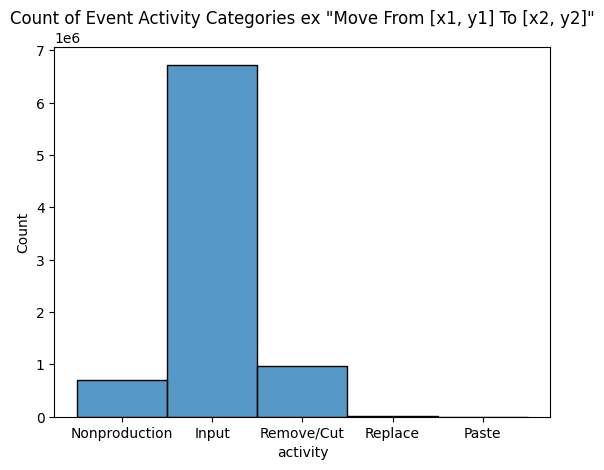

In [10]:
sns.histplot(train_logs[~train_logs['activity'].str.startswith('Move')].activity);
plt.title('Count of Event Activity Categories ex "Move From [x1, y1] To [x2, y2]"');

#### down_event, up_event, text_change 

The documentation specifies that all alphanumeric character inputs have been substituted with the "anonymous" character `q`.

In [11]:
train_logs.text_change.value_counts()[:10]

text_change
q           6128208
            1376829
NoChange     703851
.             67797
,             54797
\n            27977
'             13192
"              4659
-              4492
?              3507
Name: count, dtype: int64

In [12]:
train_logs.down_event.unique()

array(['Leftclick', 'Shift', 'q', 'Space', 'Backspace', '.', ',', 'Enter',
       'ArrowLeft', "'", ';', 'ArrowRight', '-', '?', 'Tab', '"',
       'ArrowUp', 'ArrowDown', 'Rightclick', '=', 'CapsLock', 'Control',
       'c', 'v', '/', 'Delete', ':', 'z', '[', '$', '(', ')', '+', 'Home',
       'End', '\\', 'Meta', '*', '&', 'AudioVolumeMute', 'x', '!',
       'Insert', 'MediaPlayPause', 'NumLock', '%', 'V', '>', 'Alt',
       'AudioVolumeUp', 'ContextMenu', 'AudioVolumeDown', 'a', '<',
       'PageDown', ']', 'Middleclick', '@', 'F12', 'j', '\x96', 'Dead',
       't', 's', 'n', 'y', '{', 'ScrollLock', '¿', 'Process', '}',
       'MediaTrackPrevious', 'MediaTrackNext', 'F3', '^', 'Unidentified',
       'Cancel', '2', 'i', 'd', 'r', 'e', '`', '\x9b', 'm', '#', '~',
       'PageUp', 'T', 'A', 'b', 'S', 'ModeChange', '_', 'Escape', 'F11',
       'Unknownclick', 'AltGraph', 'F10', 'h', 'F15', 'Clear', 'OS', 'F',
       'C', 'o', 'Ä±', 'f', 'u', 'w', 'p', 'g', 'M', 'l', '|',
       'â\x80\x

In [13]:
train_logs.down_event.value_counts()[:10]

down_event
q             5365319
Space         1207128
Backspace      964089
Shift          334227
ArrowRight     121338
Leftclick       91126
ArrowLeft       63217
.               59586
,               46806
ArrowDown       30874
Name: count, dtype: int64

- **Hypothesis to explore**: Better handling of keyboard shortcuts could be associated with higher competence

In [14]:
# We will focus on 'Control key' events
train_logs['num_control_key'] = train_logs.groupby('id')['down_event'].transform(lambda x: (x == 'Control').sum())

simplified_train_logs = simplified_train_logs.merge(train_logs[['id', 'num_control_key']].drop_duplicates(), on='id', how='left')
simplified_train_logs.drop('id', axis=1, inplace=True)

In [15]:
# Verifying that the choice between 'down_event' and 'up_event' is inconsequential
is_choice_irrelevant = (train_logs.groupby('id')['down_event'].transform(lambda x: (x == 'Control').sum())
                        == train_logs.groupby('id')['up_event'].transform(lambda x: (x == 'Control').sum())).mean()

print(f"The result of is_choice_irrelevant: {bool(is_choice_irrelevant)},", 
      "confirms that the values for 'down_event' and 'up_event' coincide when either of them is 'Control'.")

The result of is_choice_irrelevant: True, confirms that the values for 'down_event' and 'up_event' coincide when either of them is 'Control'.


Percentage of essays with at least one event ('down_event') involving the Control key: 18.5%




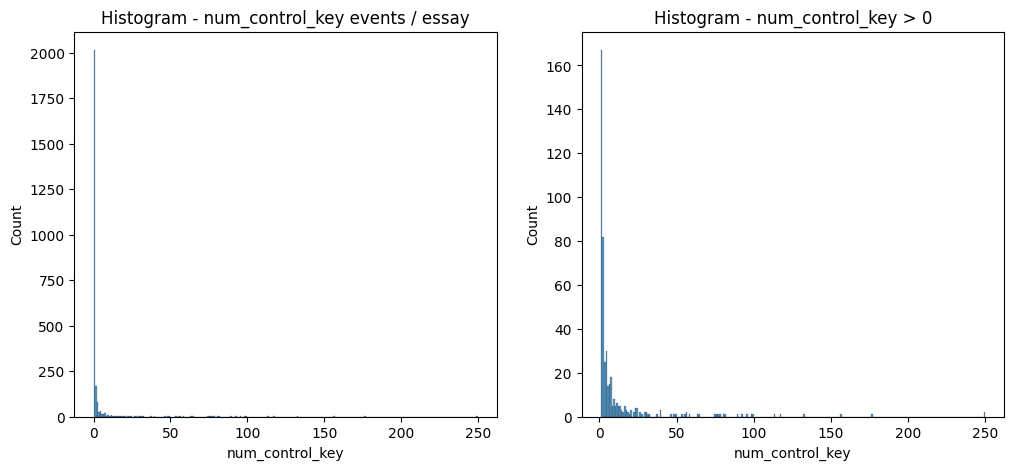

In [16]:
# Observing values of new feature 'num_control_key'
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(simplified_train_logs.num_control_key, binwidth=1, ax=axes[0])
axes[0].set_title('Histogram - num_control_key events / essay')

sns.histplot(simplified_train_logs[simplified_train_logs.num_control_key > 0].num_control_key, binwidth=1, ax=axes[1])
axes[1].set_title('Histogram - num_control_key > 0');

print("Percentage of essays with at least one event ('down_event') involving the Control key:",
      f"{np.round(100 * len(simplified_train_logs[simplified_train_logs.num_control_key != 0]) / len(simplified_train_logs), 1)}%\n\n")

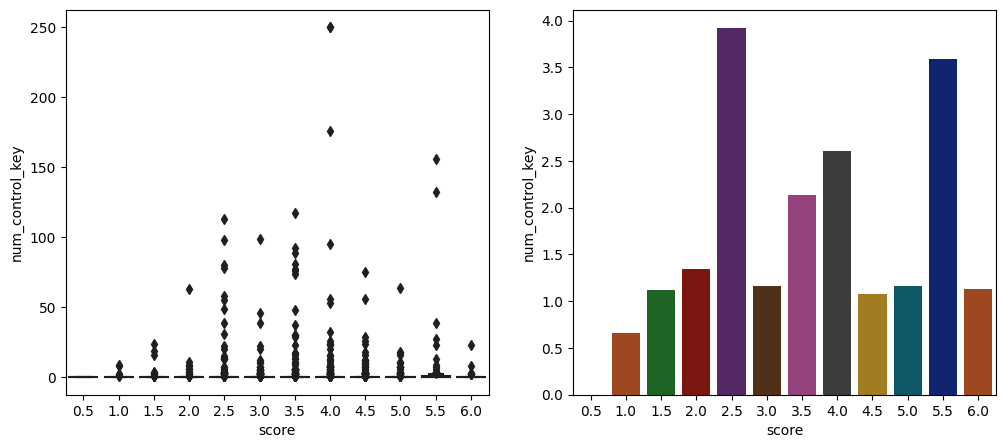

In [17]:
# Checking correlation of 'num_control_key' vs 'score'
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x=train_scores.score, y=simplified_train_logs.num_control_key, palette='dark', ax=axes[0]);
sns.barplot(x=train_scores.score, y=simplified_train_logs.num_control_key, ci=None, palette='dark', ax=axes[1]);

We can infer that there is no discernible correlation between use of 'Control key' vs 'score'. 

Nevertheless, we will keep the feature for potential interactions with other features.

#### num_events

The average number of events per essay is 3402.0


<Axes: xlabel='num_events', ylabel='Count'>

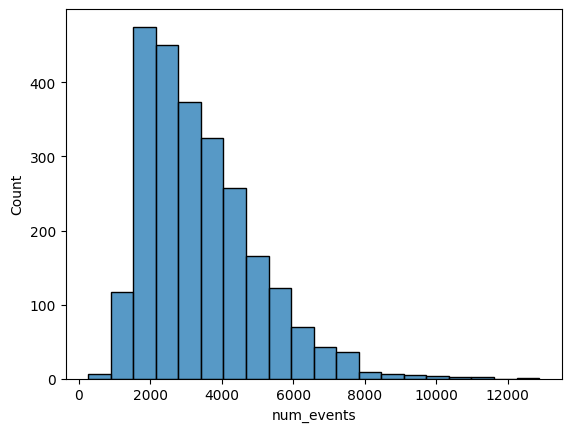

In [18]:
print(f'The average number of events per essay is {np.round(simplified_train_logs.num_events.mean(), 0)}')
sns.histplot(data=simplified_train_logs, x='num_events', bins=20)

For machine learning models, it becomes challenging to effectively learn and make accurate predictions when certain features

exhibit a range of values with infrequent occurrences. We will try some approaches to mitigate that handicap, later on.

Is there a correlation between `num_events` and `score`?


				The graph on the right illustrates the average value of num_events for each score.




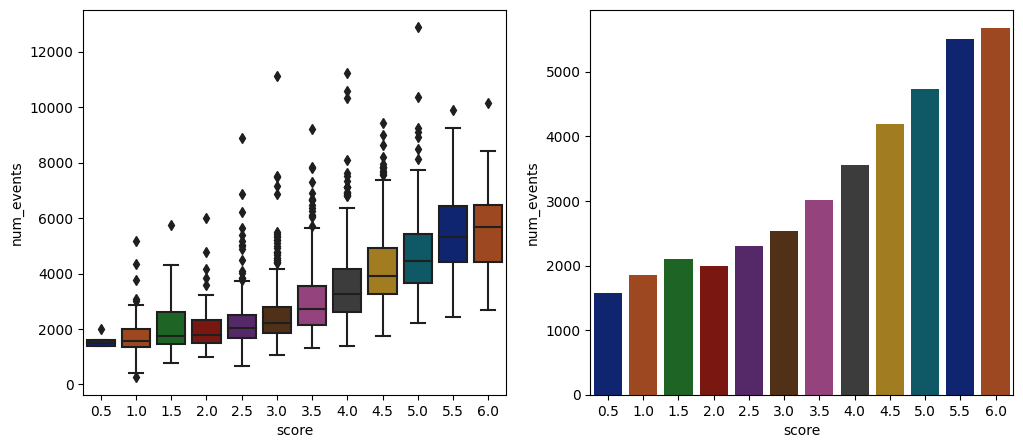

In [19]:
print("\n\t\t\t\tThe graph on the right illustrates the average value of num_events for each score.\n\n")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x=train_scores.score, y=simplified_train_logs.num_events, palette='dark', ax=axes[0]);
sns.barplot(x=train_scores.score, y=simplified_train_logs.num_events, ci=None, palette='dark', ax=axes[1]);

Indeed, there appears to be a positive correlation between `num_events` and `score`.

Now, let's check possible correlations between the target variable `score` and the rest of features:

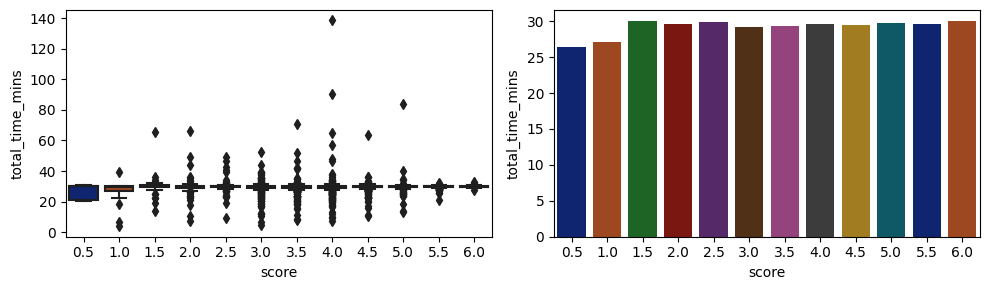

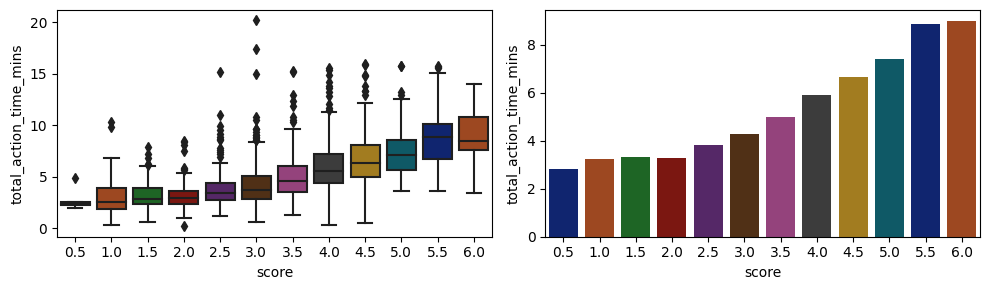

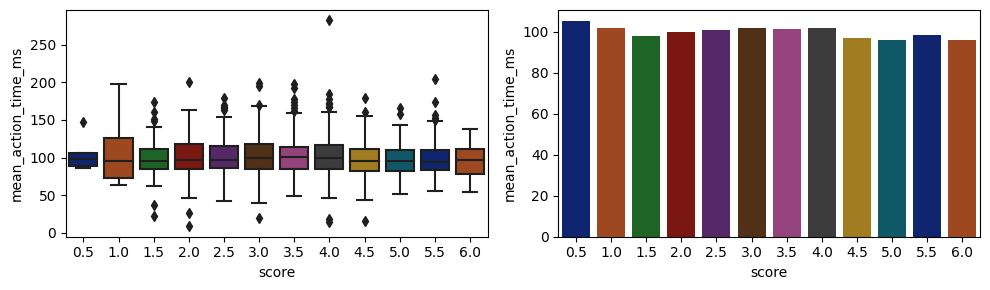

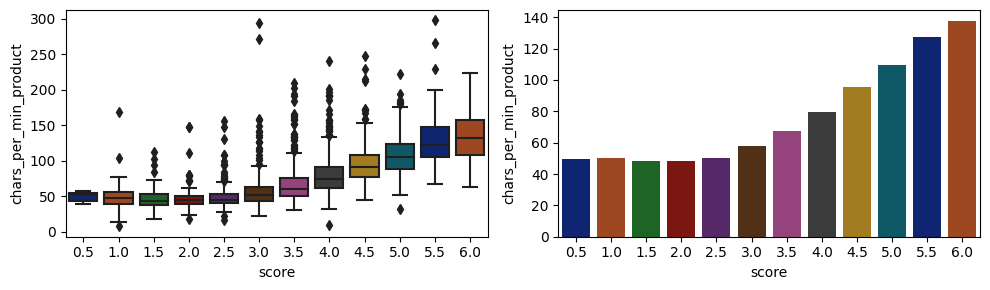

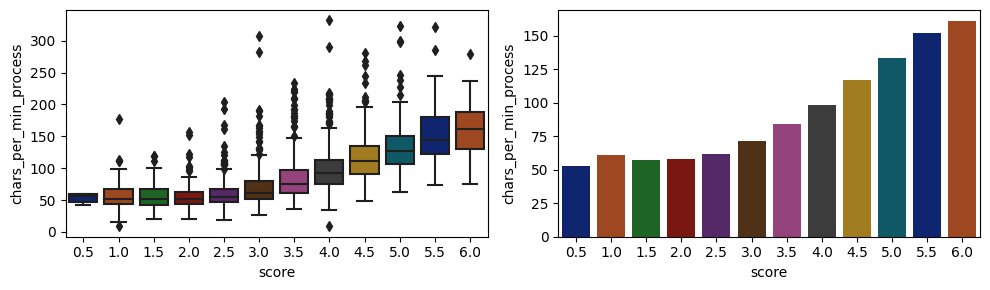

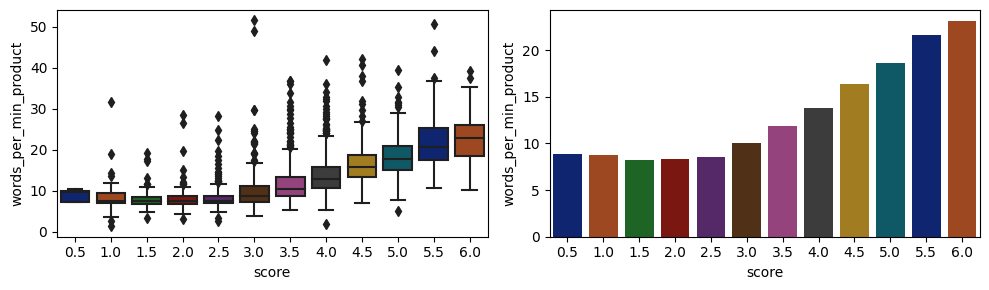

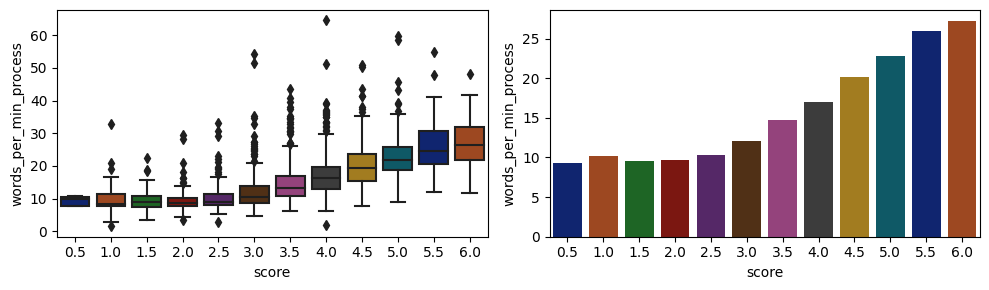

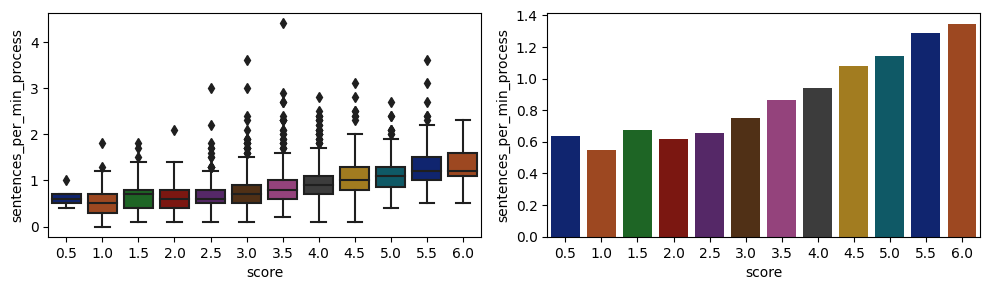

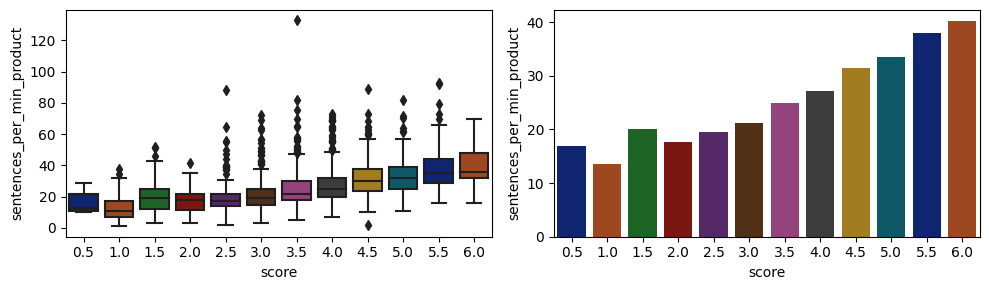

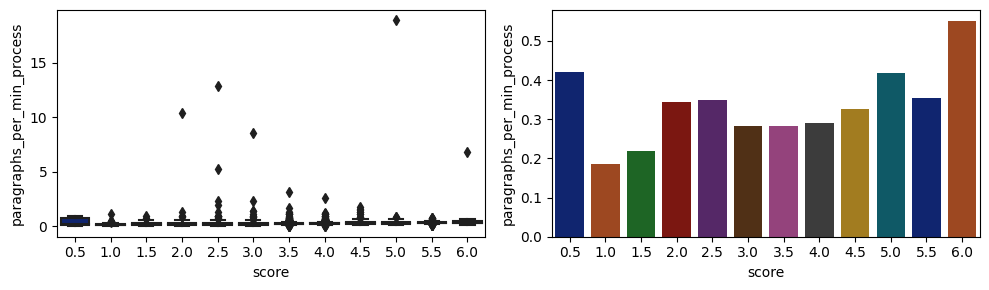

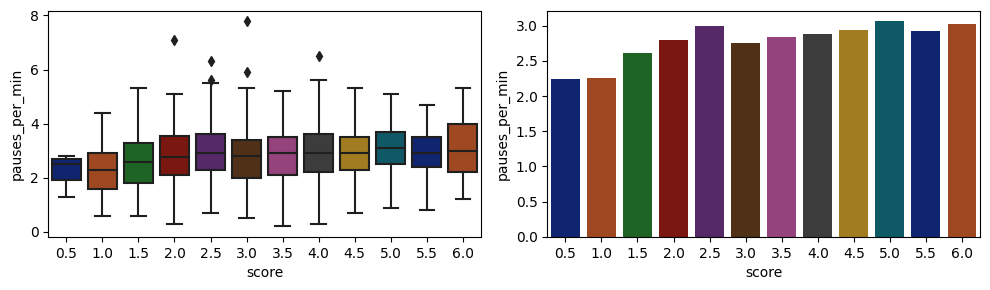

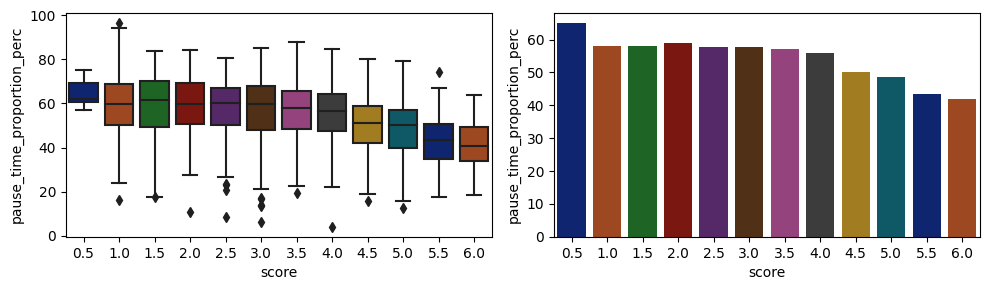

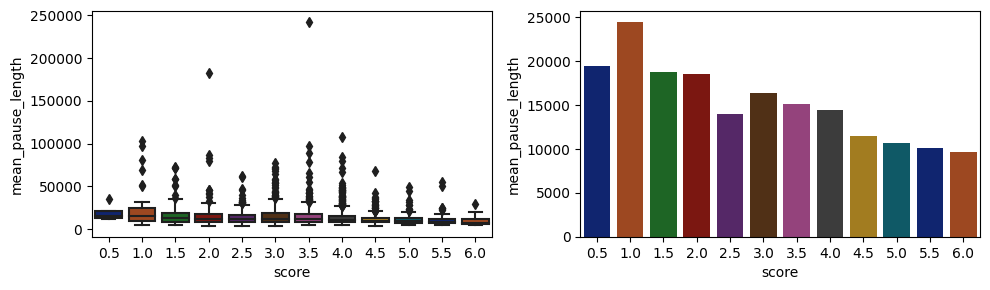

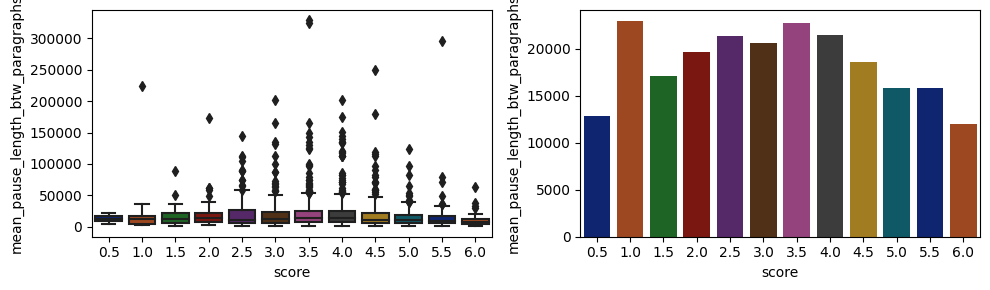

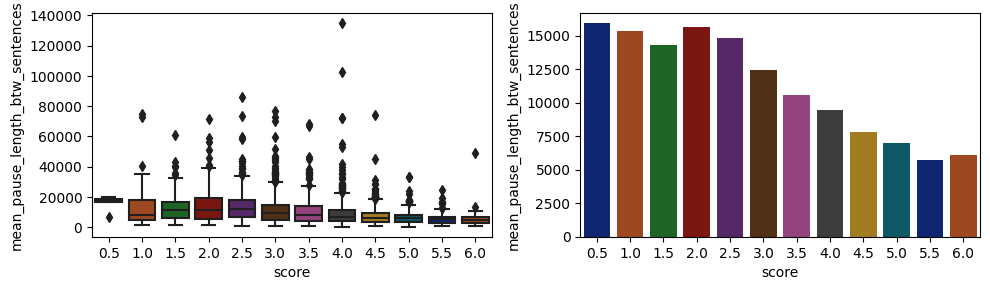

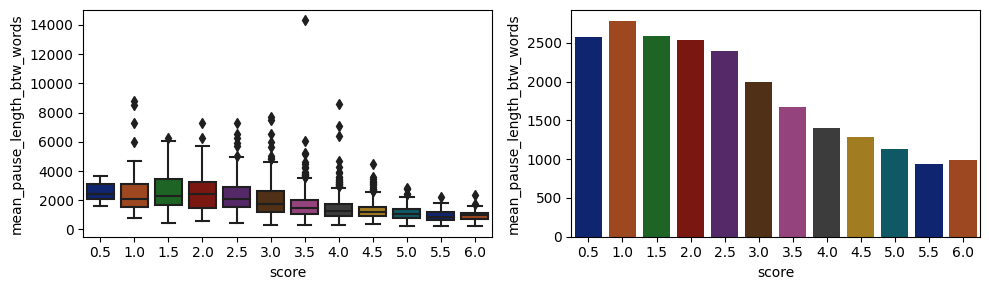

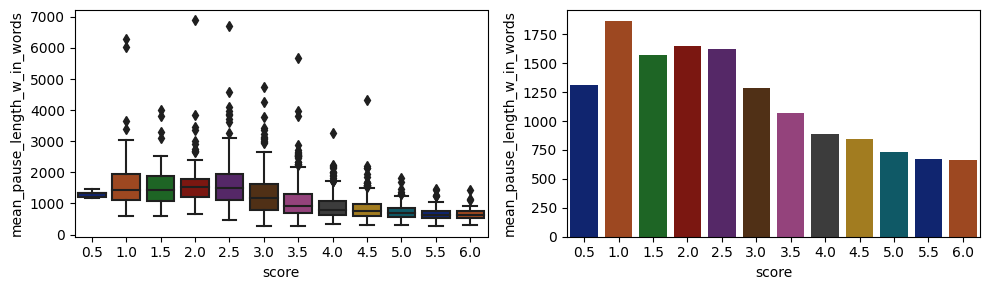

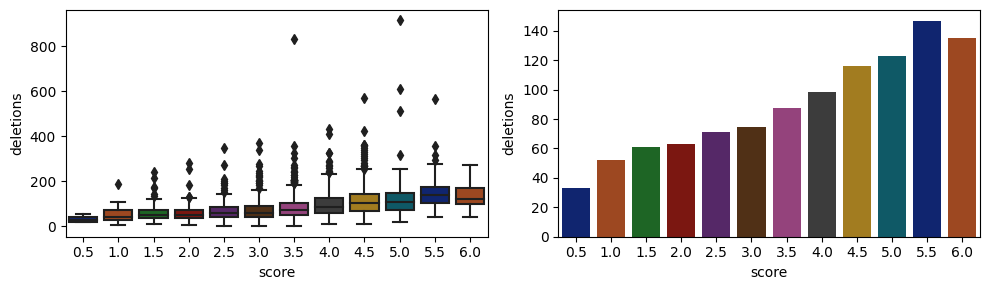

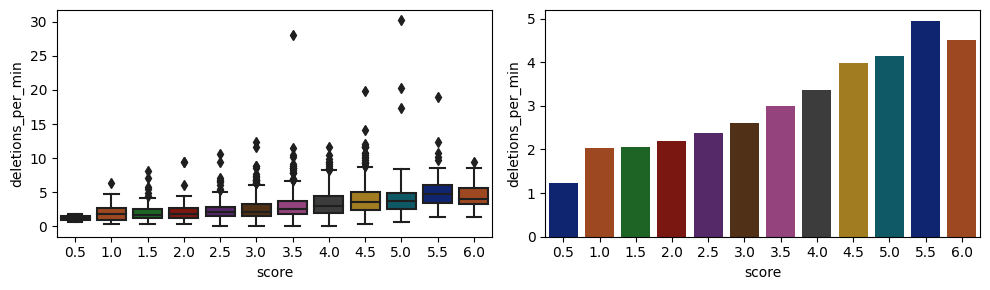

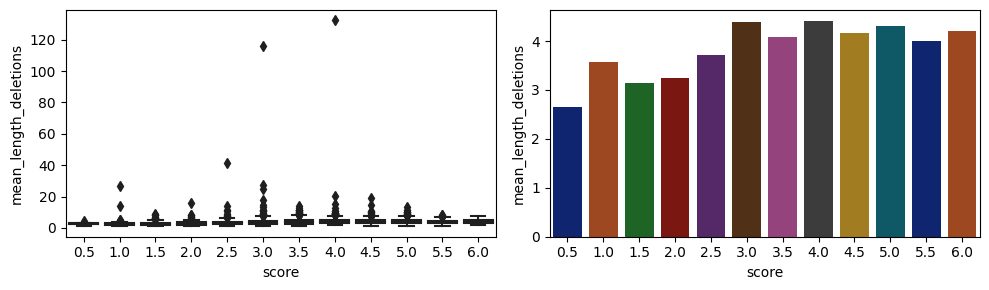

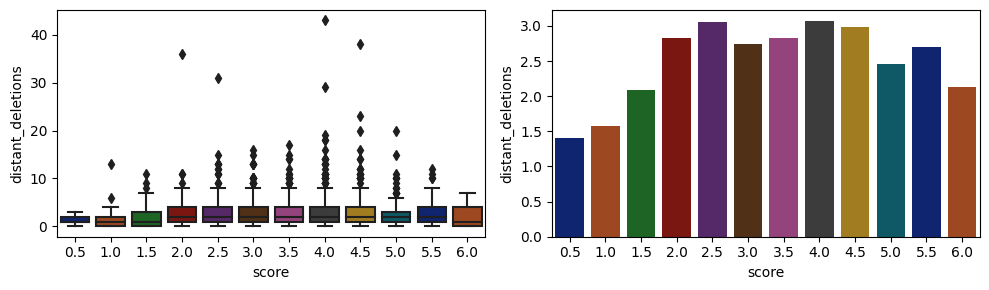

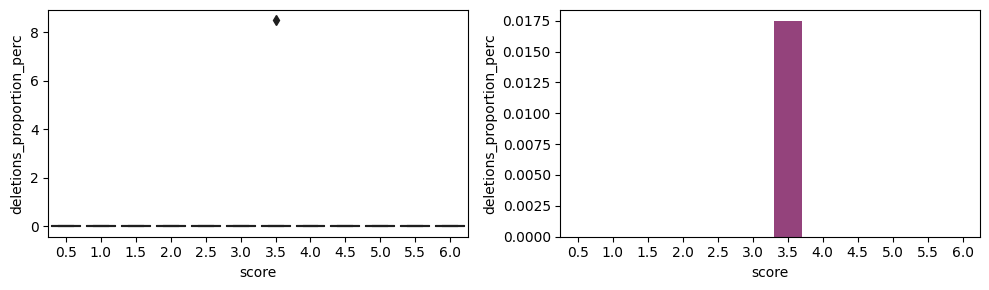

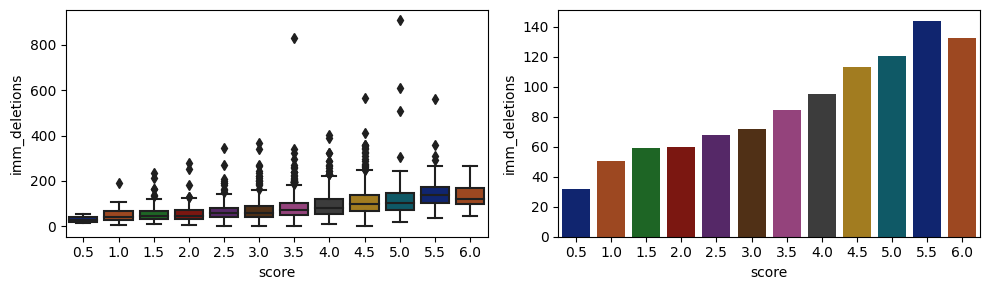

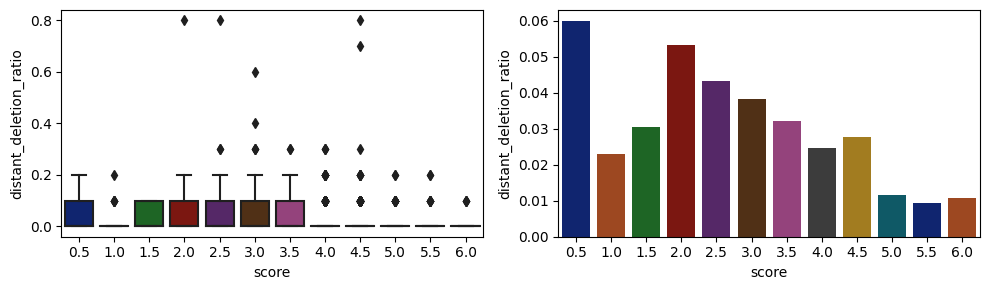

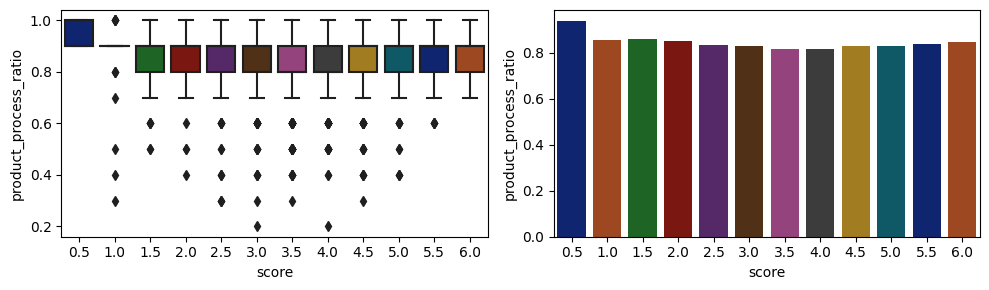

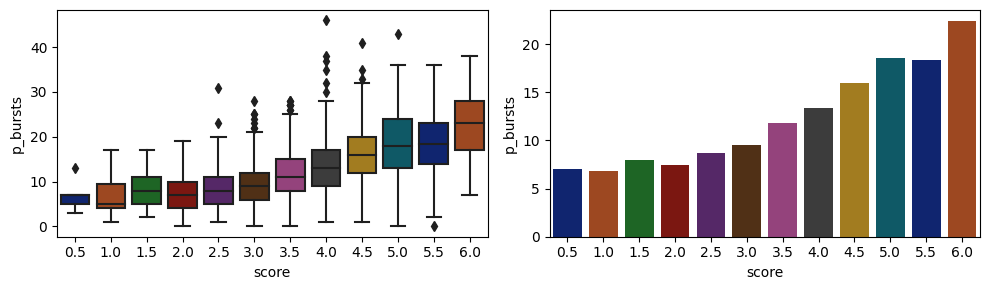

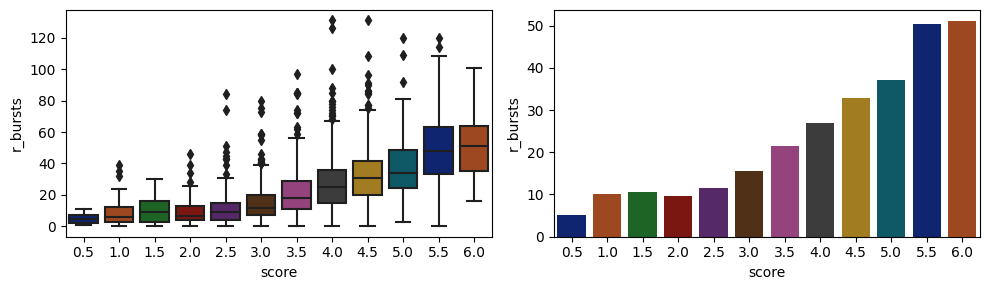

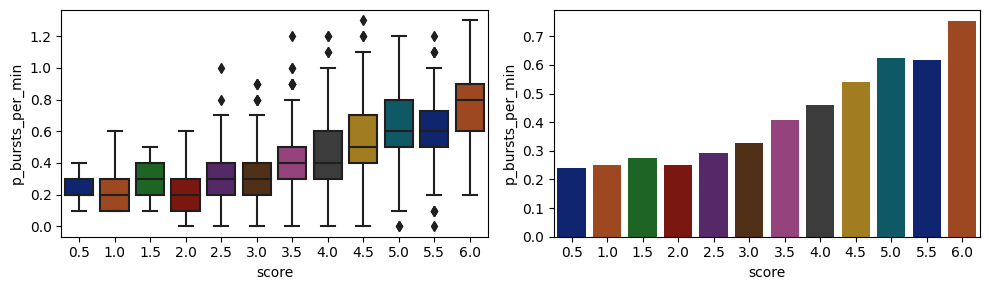

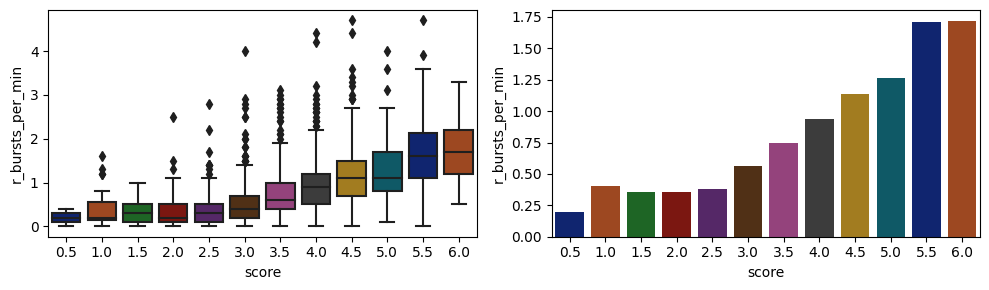

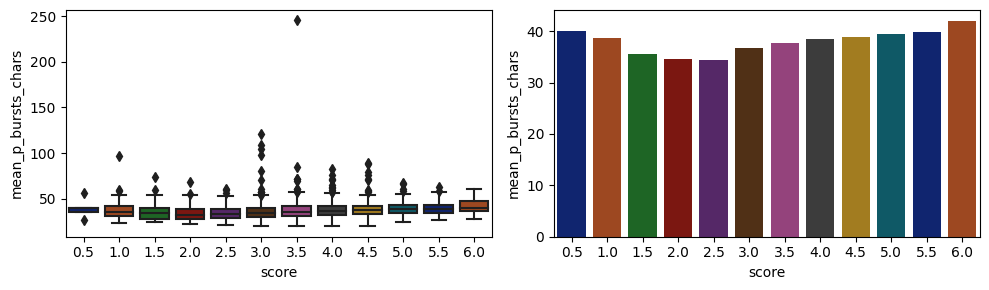

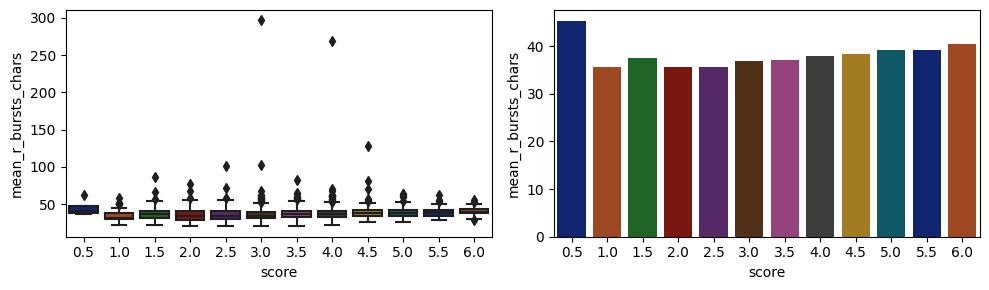

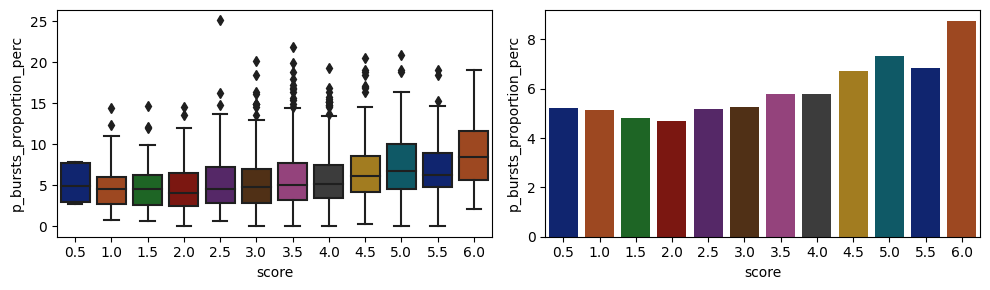

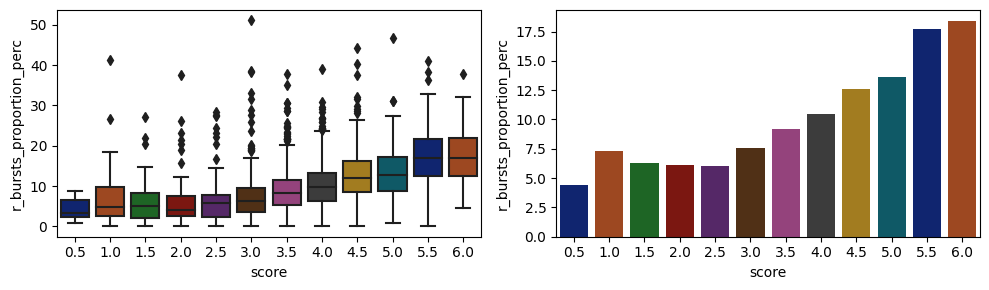

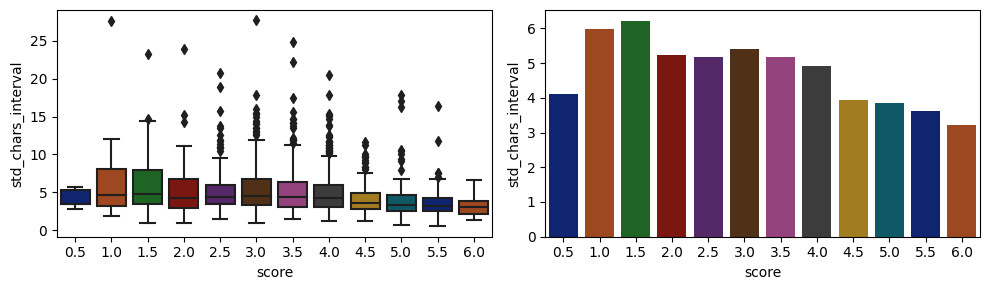

In [20]:
for column in simplified_train_logs.columns:
    if column not in ('num_control_key', 'num_events'):
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        sns.boxplot(x=train_scores.score, y=simplified_train_logs[column], palette='dark', ax=axes[0]);
        sns.barplot(x=train_scores.score, y=simplified_train_logs[column], ci=None, palette='dark', ax=axes[1]);
        plt.tight_layout()
        plt.show()

We can observe clearly some positive correlations with the features: `total_action_time_mins, chars_per_min_product,`

`chars_per_min_process, words_per_min_product, words_per_min_process, sentences_per_min_process, sentences_per_min_product,`

`deletions, deletions_per_min, imm_deletions, p_bursts, r_bursts, p_bursts_per_min, r_bursts_per_min,` 

`bursts_proportion_perc, r_bursts_proportion_perc`. There are negative correlations with the following features, as well:

`pause_time_proportion_perc, mean_pause_length_btw_sentences, mean_pause_length_btw_words,` 

`mean_pause_length_w_in_words`.

Afterwards, correlations among those features will be analyzed, and some of them will be descarded as a result.

- **Other hypothesis to explore**:
    *  Best writers have more clarity of thought -> less corrections - keystroke features
    
    *  Best writers spend a larger share of time reviewing - keystroke features

    *  Best writers spend a larger share of time thinking, in pause - keystroke features
    
    *  Best writers spend a larger share of time in bursts (better short-term memory) - keystroke features
    
    *  Volume-related events: tendency to get distracted - tiny sample 
    
    *  Volume-related events: focused if shutting down noise  - tiny sample
    
    *  Those with more periods of inactivity have lower performance - keystroke features
    
<br>


Several hypotheses were rejected due to the limited sample sizes, while others required the introduction of novel features

(keystroke features created in the file 'keystroke-measures'). The efficacy of these newly introduced features will be

assessed by machine learning models to ascertain their utility or lack thereof.

## Feature Engineering

In [21]:
print("Null Values found in simplified_train_logs:\n")
print(simplified_train_logs.isna().sum().sort_values(ascending=False)[:6])
simplified_train_logs.fillna(0, inplace=True)

Null Values found in simplified_train_logs:

mean_pause_length_btw_paragraphs    614
mean_r_bursts_chars                  30
mean_pause_length_btw_sentences      20
mean_p_bursts_chars                   9
mean_length_deletions                 1
distant_deletion_ratio                1
dtype: int64


In [22]:
simplified_train_logs.columns

Index(['num_events', 'total_time_mins', 'total_action_time_mins',
       'mean_action_time_ms', 'chars_per_min_product', 'chars_per_min_process',
       'words_per_min_product', 'words_per_min_process',
       'sentences_per_min_process', 'sentences_per_min_product',
       'paragraphs_per_min_process', 'pauses_per_min',
       'pause_time_proportion_perc', 'mean_pause_length',
       'mean_pause_length_btw_paragraphs', 'mean_pause_length_btw_sentences',
       'mean_pause_length_btw_words', 'mean_pause_length_w_in_words',
       'deletions', 'deletions_per_min', 'mean_length_deletions',
       'distant_deletions', 'deletions_proportion_perc', 'imm_deletions',
       'distant_deletion_ratio', 'product_process_ratio', 'p_bursts',
       'r_bursts', 'p_bursts_per_min', 'r_bursts_per_min',
       'mean_p_bursts_chars', 'mean_r_bursts_chars',
       'p_bursts_proportion_perc', 'r_bursts_proportion_perc',
       'std_chars_interval', 'num_control_key'],
      dtype='object')

In [23]:
# feature clusters
production_cluster = ['chars_per_min_product', 'chars_per_min_process', 'words_per_min_product', 
                      'words_per_min_process', 'sentences_per_min_process', 'sentences_per_min_product',
                      'paragraphs_per_min_process']
pause_cluster = ['pauses_per_min', 'pause_time_proportion_perc', 'mean_pause_length', 
                 'mean_pause_length_btw_paragraphs', 'mean_pause_length_btw_sentences',
                 'mean_pause_length_btw_words', 'mean_pause_length_w_in_words']
deletions_cluster = ['deletions', 'deletions_per_min', 'mean_length_deletions', 'distant_deletions', 
                     'deletions_proportion_perc', 'imm_deletions', 'distant_deletion_ratio']
bursts_cluster = ['p_bursts', 'r_bursts', 'p_bursts_per_min', 'r_bursts_per_min',
                  'mean_p_bursts_chars', 'mean_r_bursts_chars', 'p_bursts_proportion_perc', 
                  'r_bursts_proportion_perc']

feature_clusters = [production_cluster, pause_cluster, deletions_cluster, bursts_cluster]
feature_clusters_str = ['production cluster', 'pause cluster', 'deletions cluster', 'bursts cluster']

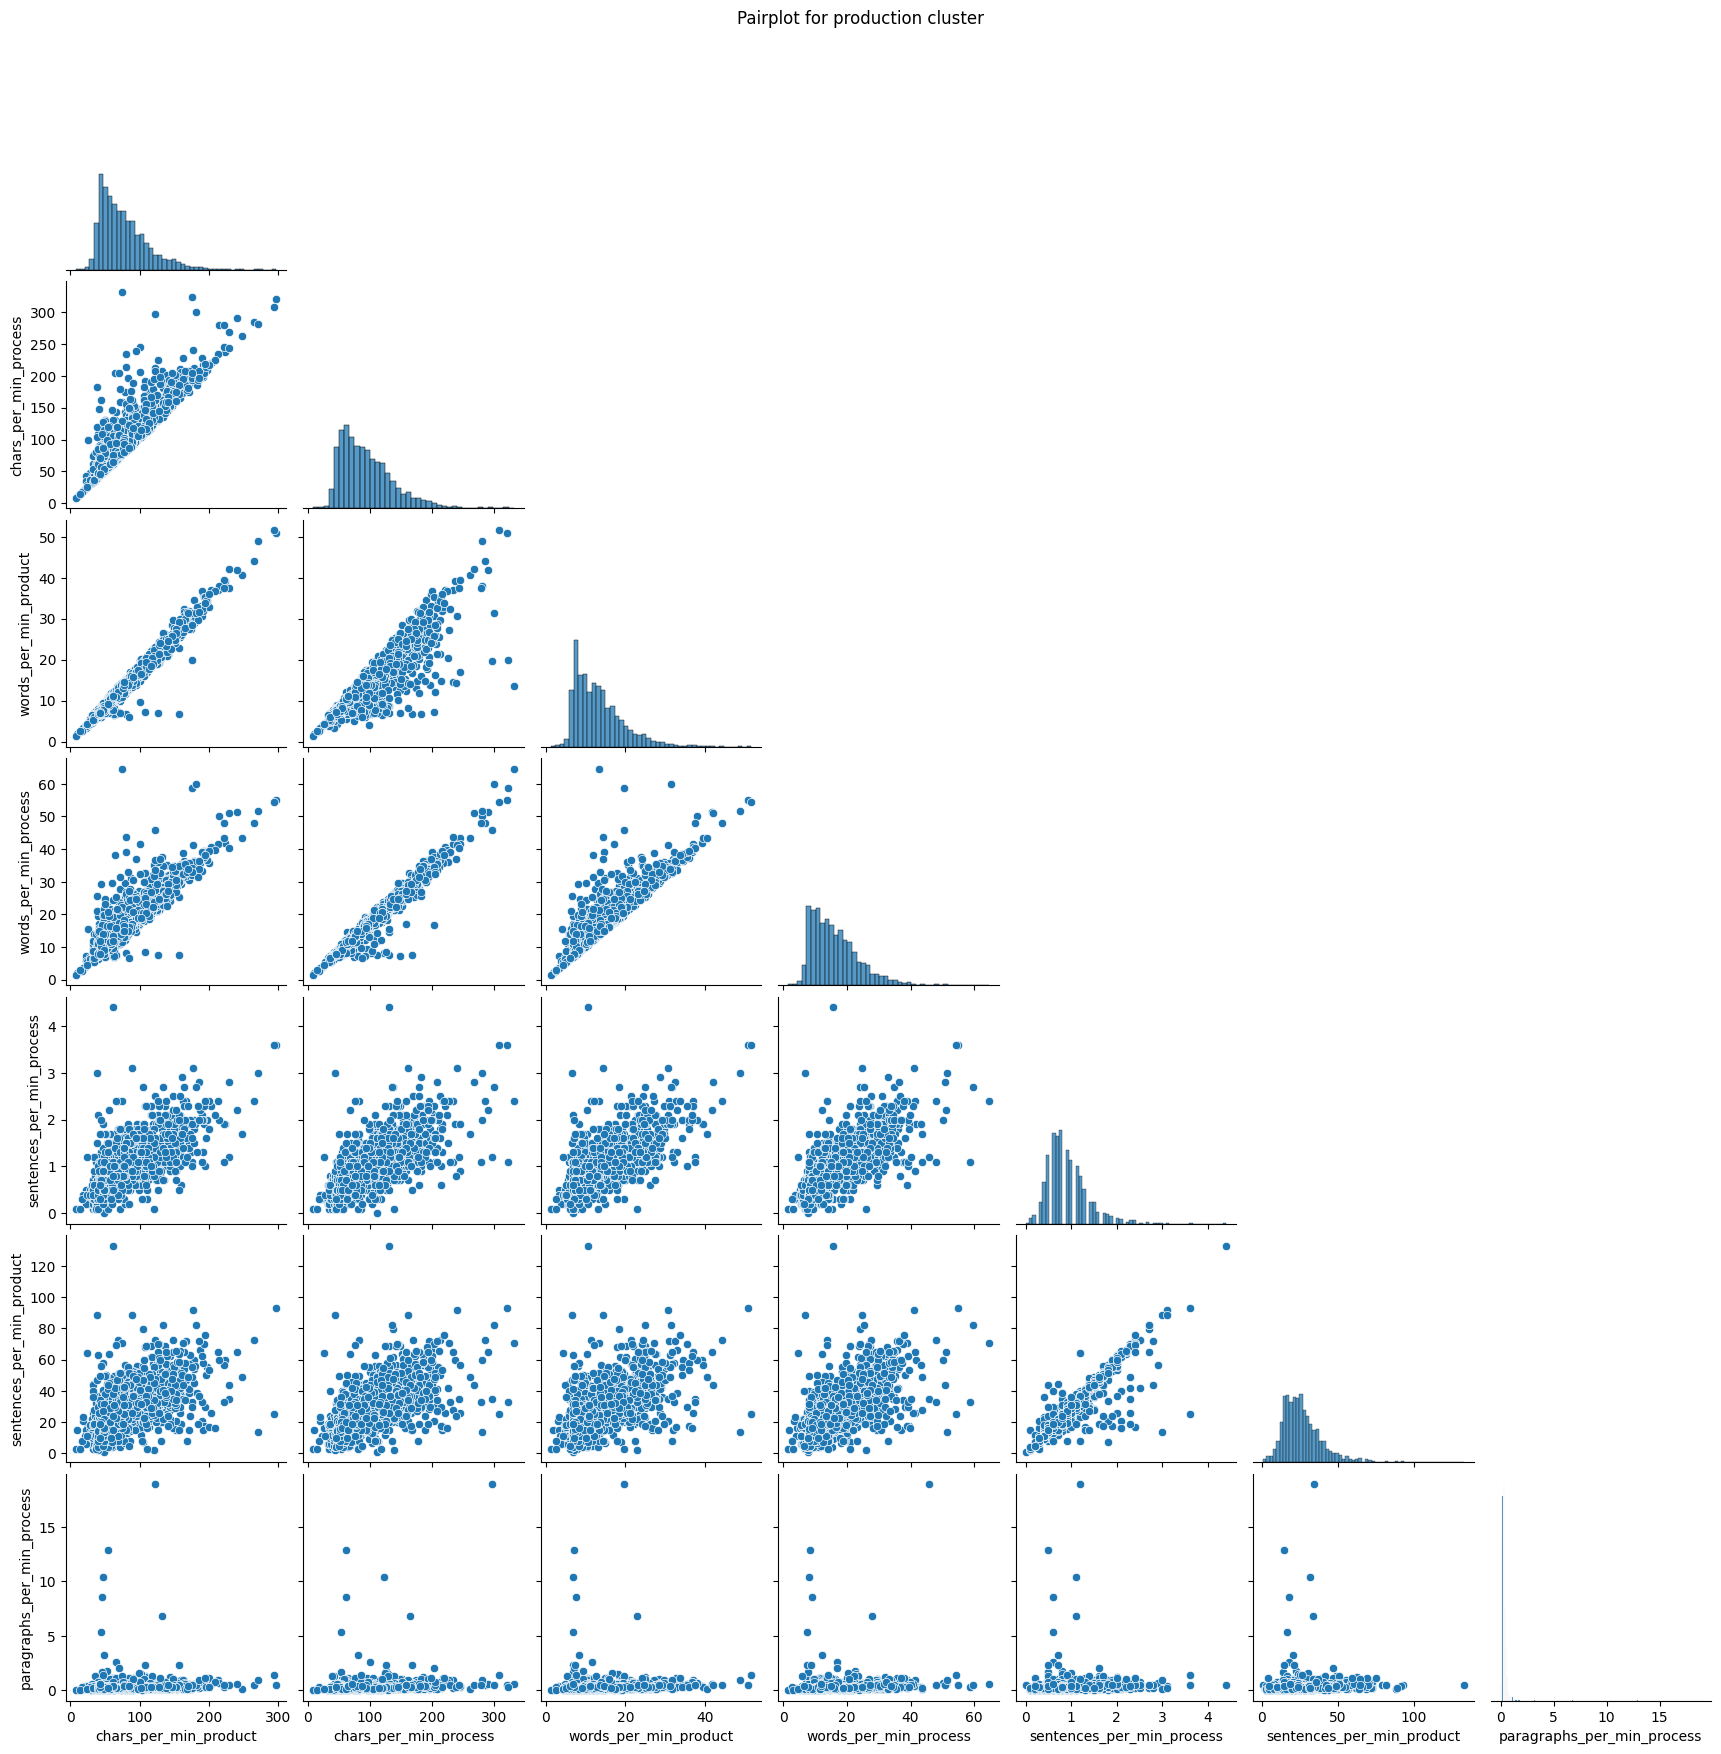

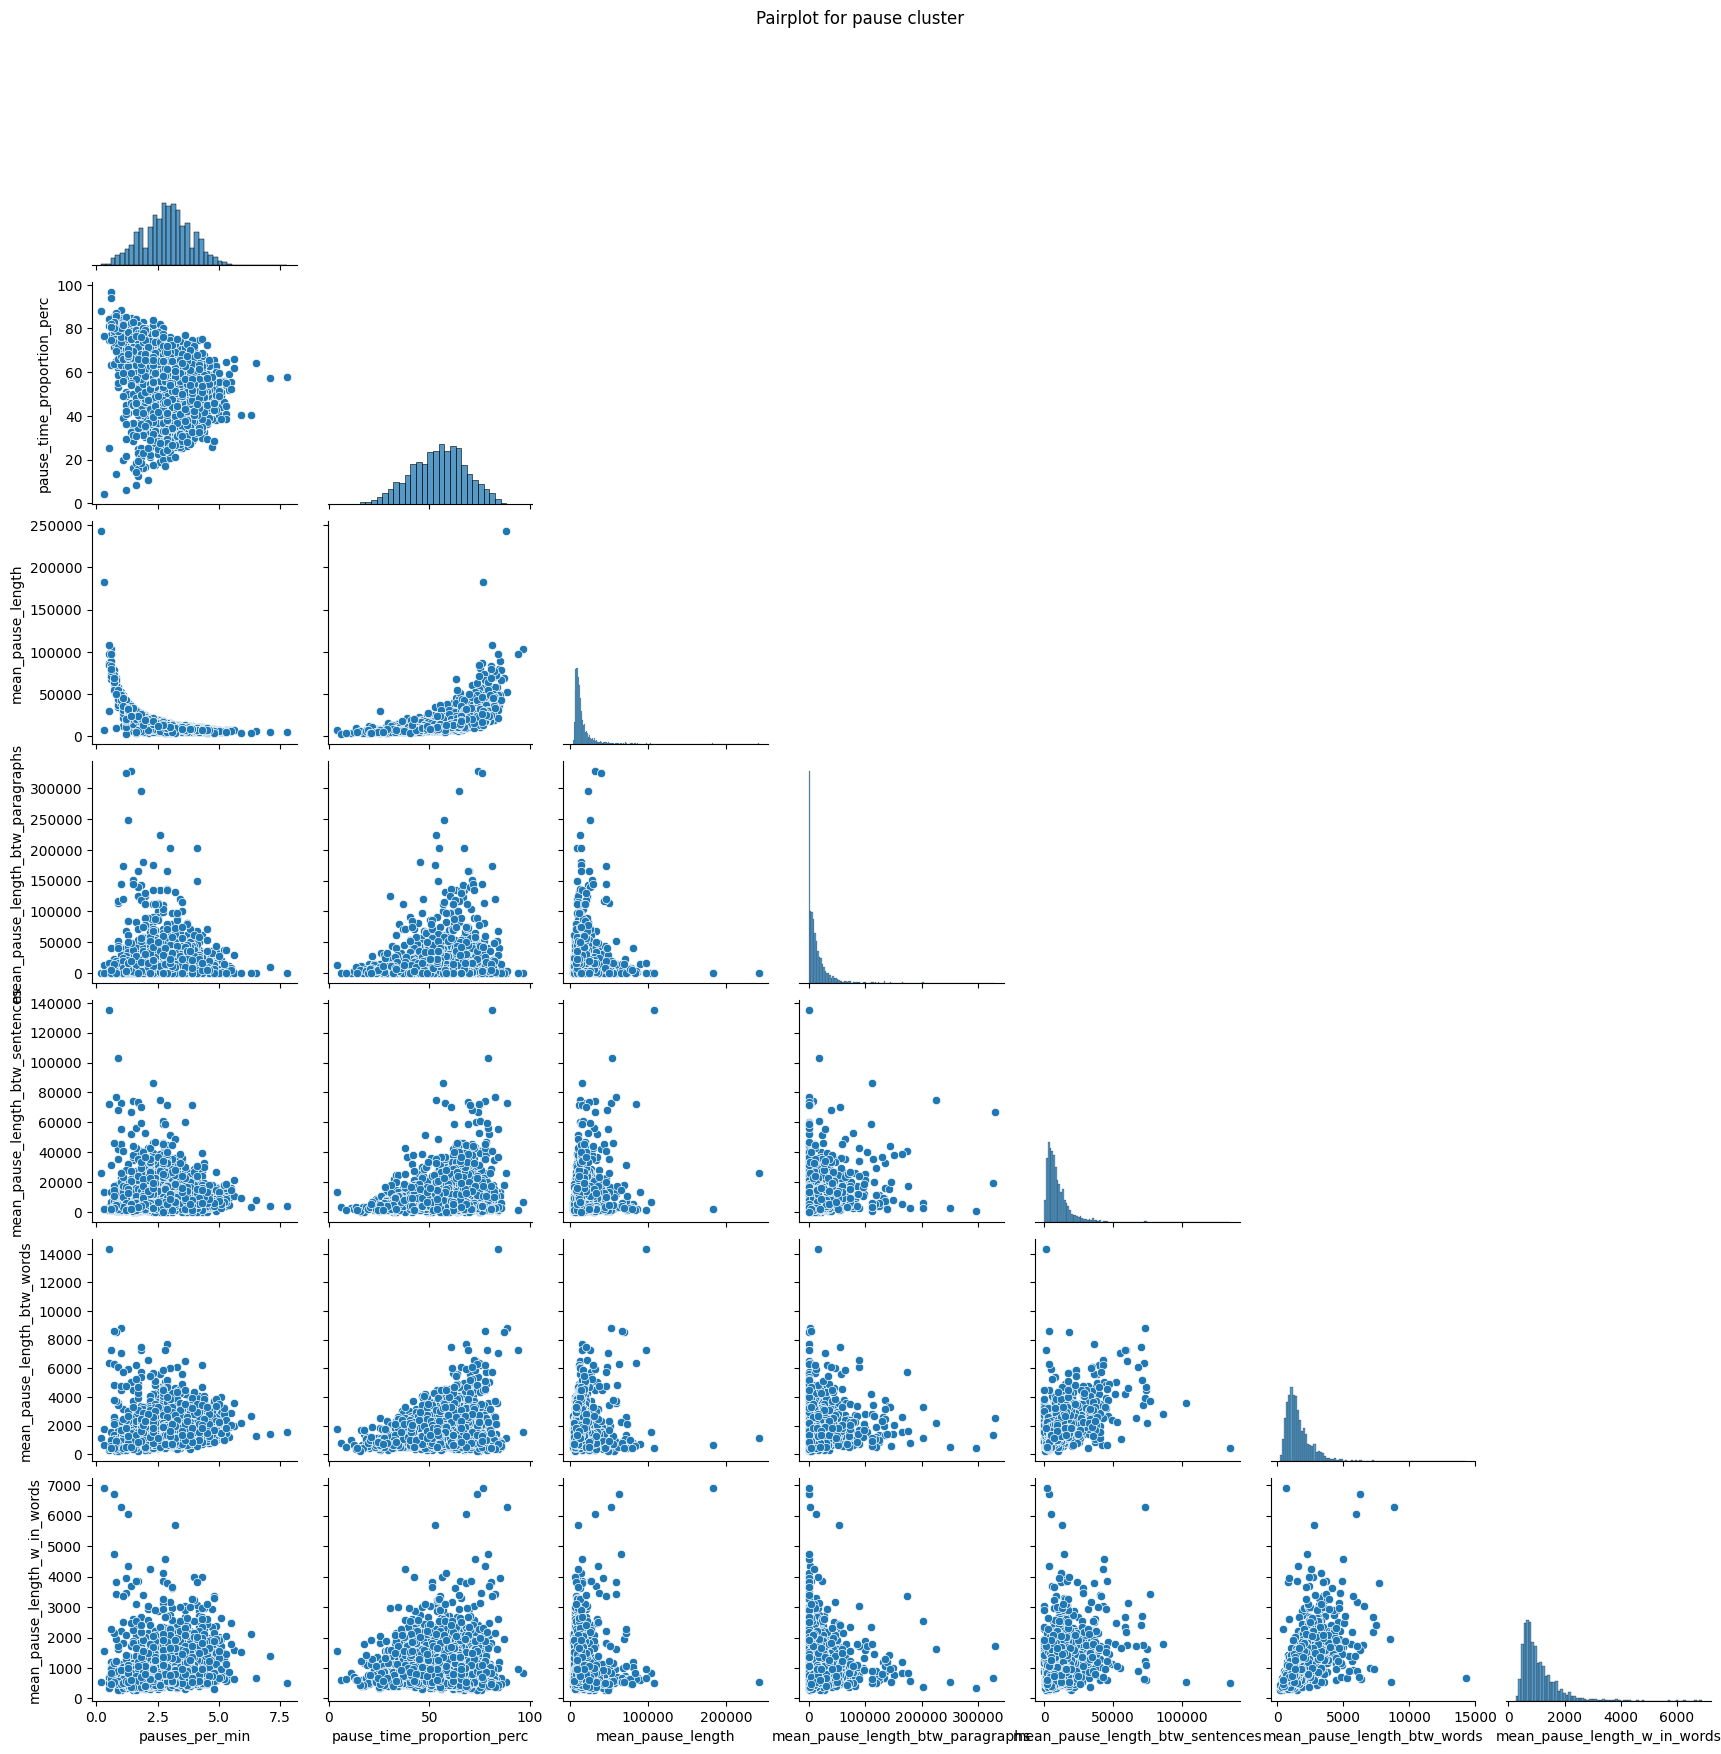

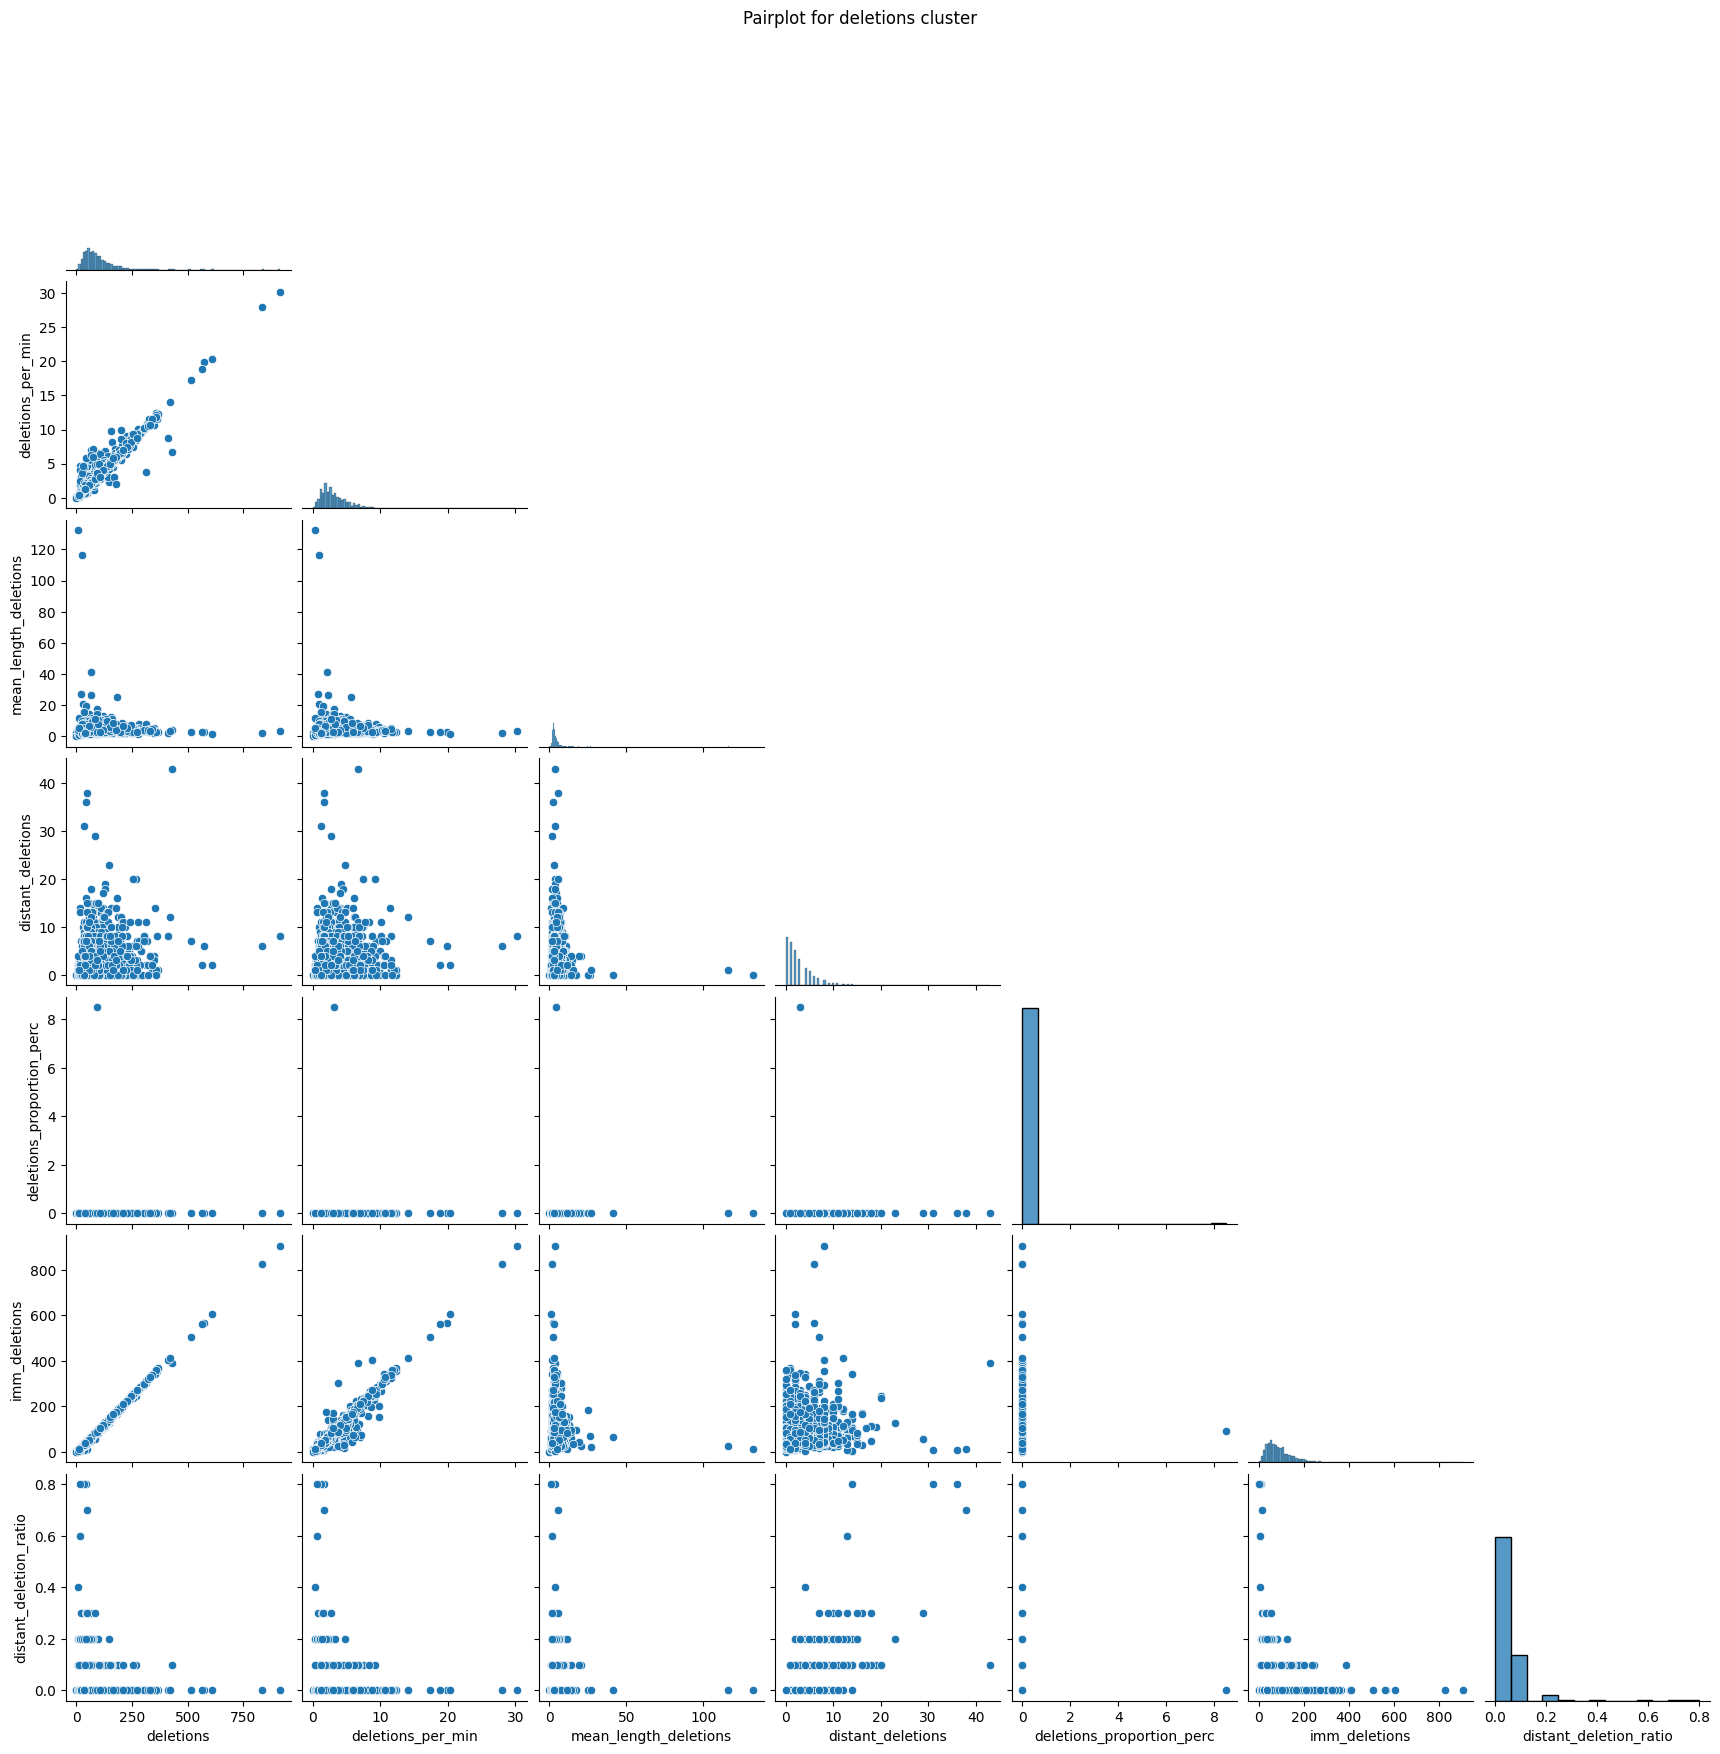

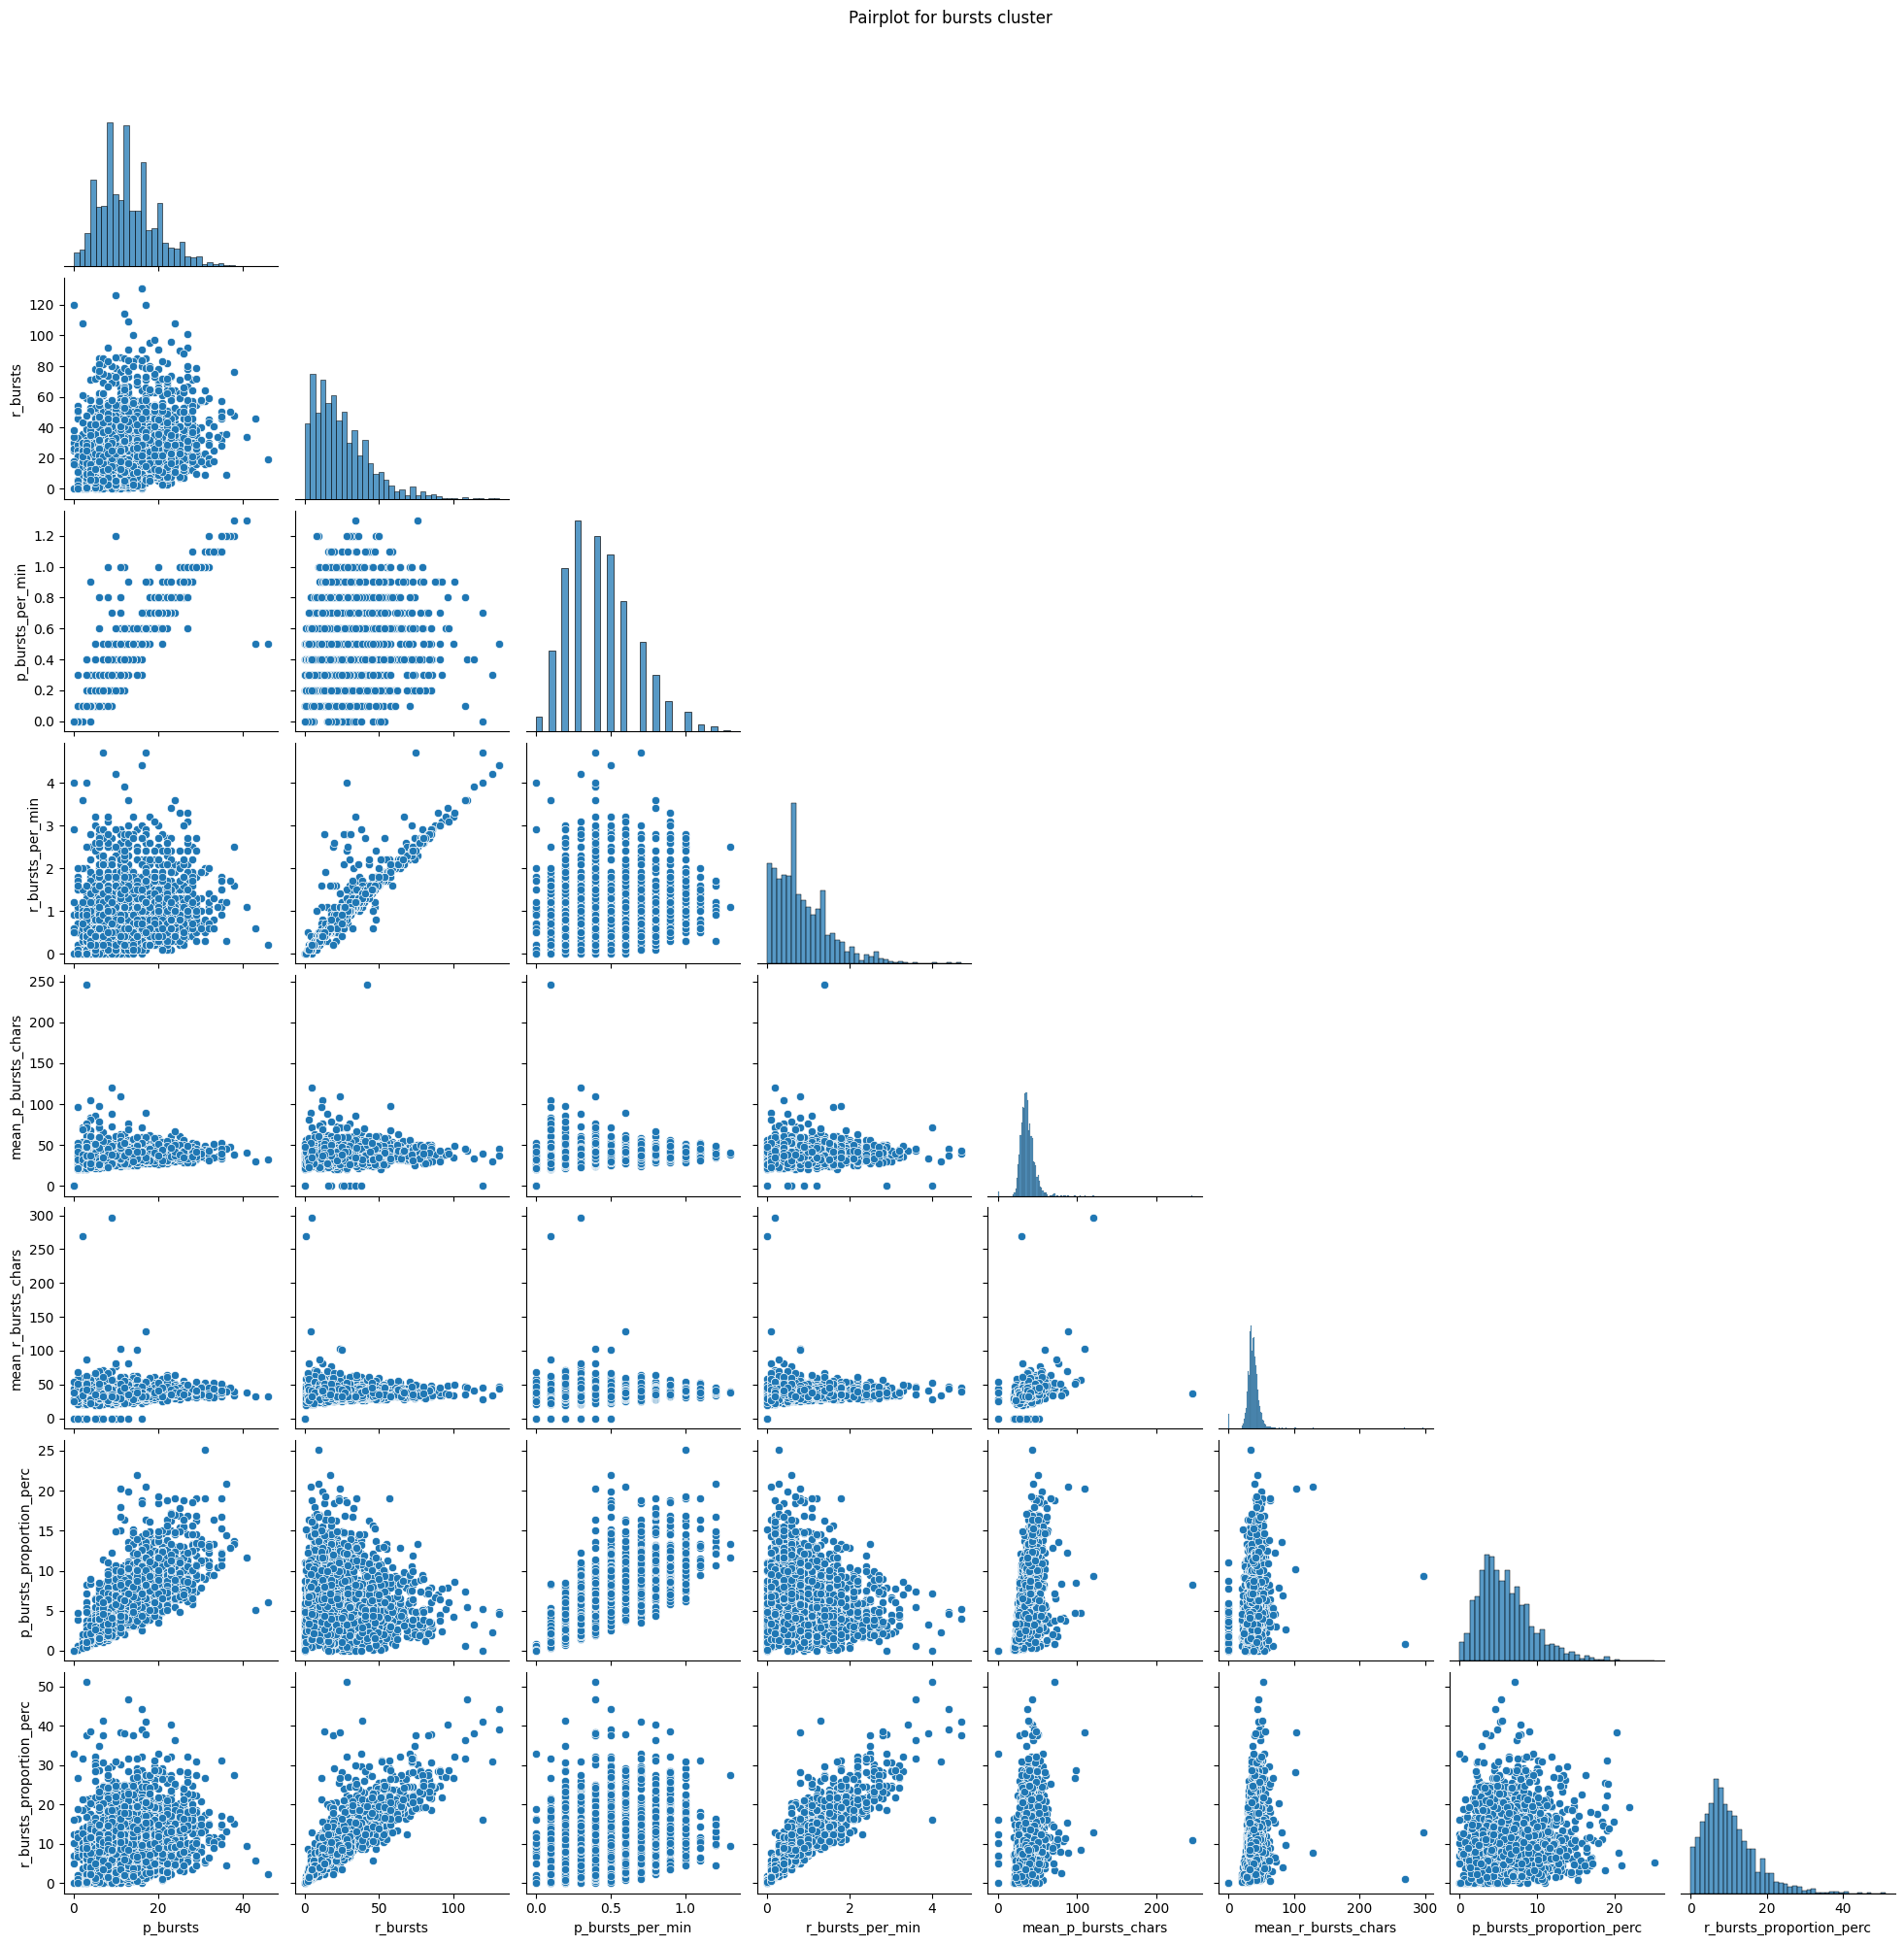

In [24]:
for i, feature_cluster in enumerate(feature_clusters):
    pair_plot = sns.pairplot(simplified_train_logs[feature_cluster], corner=True)
    pair_plot.fig.suptitle(f'Pairplot for {feature_clusters_str[i]}', y=1.005)

In [25]:
highly_correl_cols = ['chars_per_min_product', 'words_per_min_process', 'imm_deletions', 
                      'deletions_per_min', 'r_bursts_per_min']
simplified_train_logs.drop(highly_correl_cols, axis=1, inplace=True)
len(simplified_train_logs.columns)

31

In [26]:
# delete highly_correl_cols from feature_clusters
feature_clusters = [list(set(cluster) - set(highly_correl_cols)) for cluster in feature_clusters]
feature_clusters

[['paragraphs_per_min_process',
  'sentences_per_min_process',
  'sentences_per_min_product',
  'chars_per_min_process',
  'words_per_min_product'],
 ['pause_time_proportion_perc',
  'mean_pause_length_btw_paragraphs',
  'mean_pause_length_btw_sentences',
  'pauses_per_min',
  'mean_pause_length_btw_words',
  'mean_pause_length_w_in_words',
  'mean_pause_length'],
 ['distant_deletions',
  'distant_deletion_ratio',
  'deletions_proportion_perc',
  'deletions',
  'mean_length_deletions'],
 ['mean_r_bursts_chars',
  'r_bursts',
  'p_bursts',
  'mean_p_bursts_chars',
  'p_bursts_per_min',
  'p_bursts_proportion_perc',
  'r_bursts_proportion_perc']]

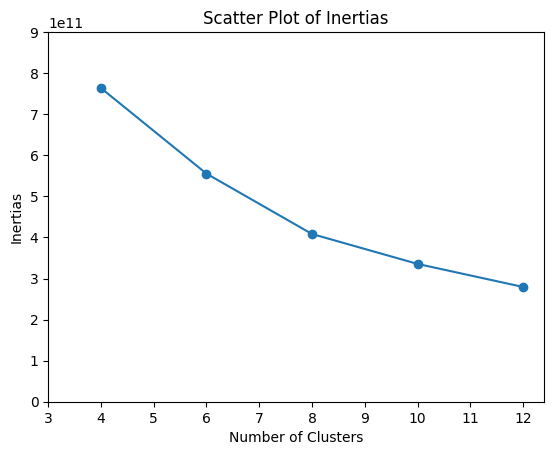

In [27]:
# to apply after split
from sklearn.cluster import KMeans
inertias = {}
for n_clusters in [4, 6, 8, 10, 12]:
    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED).fit(simplified_train_logs)
#     simplified_train_logs['kmeans_clusters'] = kmeans.labels_
    kmeans.labels_
#     print(f'\nValue counts for {n_clusters} clusters:\n', 
#           simplified_train_logs['kmeans_clusters'].value_counts())
    inertias[n_clusters] = kmeans.inertia_

num_clusters = list(inertias.keys())
inertias = list(inertias.values())

plt.plot(num_clusters, inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertias')
plt.title('Scatter Plot of Inertias')
plt.xticks(range(3, n_clusters+1, 1));
plt.yticks(range(0, 10*int(1e11), int(1e11)));

In [28]:
# plan to use tree-based models

# log transformation for skewed variables - 
# Assumption in Tree-Based Models: While tree-based models are robust 
# to the scale of features, skewed distributions may still impact the performance, 
# especially when it comes to the ability to split the data effectively.

# Also can mitigate the impact of outliers, making the tree more robust.

# Tree-based models are less sensitive to heteroscedasticity compared 
# to linear models. However, stabilizing the variance in features can 
# still contribute to a more stable and robust model.

#  If the data has a less extreme right-skewness, square root (or cube root - 
# reduces the right skewness) transformation might be more appropriate. 
# x^2 helps reduce left skewness. If the skewness is more pronounced and the 
# values span several orders of magnitude, log transformation might be a better choice.

# apply .skew() to transformation after scaling


	- PCA with 4 components:

                           Comp1     Comp2     Comp3     Comp4
Proportion of Variance  0.285157  0.109091  0.084962  0.053111

 4 components account for 53.23% of the variance.

	- PCA with 8 components:

                           Comp1     Comp2     Comp3     Comp4     Comp5  \
Proportion of Variance  0.285157  0.109091  0.084963  0.053113  0.047257   

                           Comp6     Comp7     Comp8  
Proportion of Variance  0.042575  0.039239  0.037168  

 8 components account for 69.86% of the variance.

	- PCA with 12 components:

                           Comp1     Comp2     Comp3     Comp4     Comp5  \
Proportion of Variance  0.285157  0.109091  0.084963  0.053113  0.047257   

                           Comp6    Comp7     Comp8     Comp9    Comp10  \
Proportion of Variance  0.042575  0.03924  0.037169  0.034007  0.032456   

                          Comp11    Comp12  
Proportion of Variance  0.031727  0.029368  

 12 components account for 82

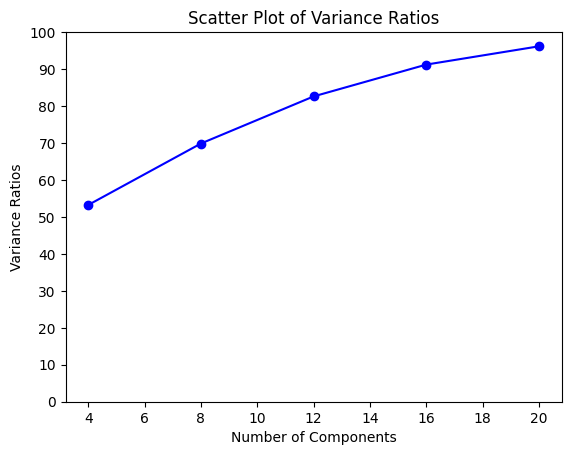

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
simplified_train_logs_scaled = scaler.fit_transform(simplified_train_logs)

# Loop over the number of PCA components
var_ratios = {}
for n_components in [4, 8, 12, 16, 20]:
    print(f'\n\t- PCA with {n_components} components:\n')
    
    # Perform PCA
    logs_pca = PCA(n_components=n_components, random_state=SEED)
    logs_pca.fit(simplified_train_logs_scaled)
    
    # Variance ratio
    var_ratio = logs_pca.explained_variance_ratio_
    var_ratio = pd.DataFrame(var_ratio).transpose()
    var_ratio.columns = [f'Comp{i}' for i in range(1, n_components + 1)]
    var_ratio.index = ['Proportion of Variance']
    print(var_ratio)
    
    print('\n', 
          f'{n_components} components account for',
          f'{np.round(var_ratio.sum().sum() * 100, 2)}% of the variance.')
    
    var_ratios[n_components] = np.round(var_ratio.sum().sum() * 100, 2)


#     logs_pcomp = logs_pca.transform(simplified_train_logs_scaled)
#     logs_pcomp = pd.DataFrame(logs_pcomp[:, :n_components],
#                               columns=[f'Comp{i}' for i in range(1, n_components + 1)])
#     print(logs_pcomp.head())
print('\n')
keys = list(var_ratios.keys())
values = list(var_ratios.values())

plt.plot(keys, values, color='blue', marker='o', label='Variance Ratios')
plt.xlabel('Number of Components')
plt.ylabel('Variance Ratios')
plt.title('Scatter Plot of Variance Ratios')
plt.yticks(range(0, 101, 10));

In [30]:
# pca - chatgpt on splitting first
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# # Step 1: Split the data
# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# # Step 2: Standardize the data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Step 3 and 4: Apply PCA on training data and transform
# pca = PCA(n_components=desired_num_components)
# X_train_pca = pca.fit_transform(X_train_scaled)

# # Step 5: Apply the same transformation to test data
# X_test_pca = pca.transform(X_test_scaled)

## Baselines 

#### Baseline with Random Forest Classifier

In [31]:
# from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import make_scorer, mean_squared_error

# rf = RandomForestRegressor(random_state=SEED)

# X = simplified_train_logs
# y = train_scores.score

# num_folds = 5
# kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# # Define custom scorer for RMSE
# rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

# # Perform cross-validation with RMSE as the scoring metric and obtain predictions
# cv_predictions = cross_val_predict(rf, X, y, cv=kfold)

# # Display real values, predictions, max, and min predicted values for each fold
# for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
#     X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#     y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
#     predictions = cv_predictions[test_idx]

#     print(f"\nFold {fold + 1}:")
# #     print("Real Values:", y_test.values)
# #     print("Predictions:", predictions)
#     print("Max Predicted Value:", np.round(np.max(predictions),1))
#     print("Min Predicted Value:", np.round(np.min(predictions),1))

#     # Calculate and print RMSE for the fold
#     fold_rmse = np.round(np.sqrt(mean_squared_error(y_test, predictions)),2)
#     print("Fold RMSE:", fold_rmse)

# # Display the cross-validation scores
# cv_scores = cross_val_score(rf, X, y, cv=kfold, scoring=rmse_scorer)
# print("\nCross-validation RMSE scores:", -cv_scores)  # Negate scores since make_scorer uses greater_is_better=False
# print("Mean RMSE:", np.round(-cv_scores.mean(), 2))  # Negate mean as well


**Results from the previous cell** (Baseline with Random Forest Regressor):

Fold 1:
Max Predicted Value: 5.4
Min Predicted Value: 1.6
Fold RMSE: 0.61

Fold 2:
Max Predicted Value: 5.4
Min Predicted Value: 1.8
Fold RMSE: 0.73

Fold 3:
Max Predicted Value: 5.2
Min Predicted Value: 1.5
Fold RMSE: 0.68

Fold 4:
Max Predicted Value: 5.3
Min Predicted Value: 1.7
Fold RMSE: 0.71

Fold 5:
Max Predicted Value: 5.2
Min Predicted Value: 1.7
Fold RMSE: 0.66

Cross-validation RMSE scores: [0.61 0.73  0.68 0.71 0.66]


Mean RMSE: 0.68

The **submission** using this Baseline (Random Forest Regressor) achieved a score of 0.684, placing it in the top 81% of submissions.

#### Baseline with XGB Classifier

In [32]:
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor

# Set your features (X) and target variable (y)
X = simplified_train_logs
y = train_scores.score

# Set the number of folds
num_folds = 5

# Instantiate the KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

# Initialize lists to store results
max_values = []
min_values = []
rmse_scores = []

regr = XGBRegressor()

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    regr.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = regr.predict(X_test)

    # Store max and min predicted values for each fold
    max_values.append(np.round(np.max(y_pred), 2))
    min_values.append(np.round(np.min(y_pred), 2))

    # Calculate RMSE for the fold
    rmse = np.round(np.sqrt(((y_test - y_pred) ** 2).mean()), 2)
    rmse_scores.append(rmse)

    # Print RMSE for each fold
    print(f"Fold {fold} - RMSE: {rmse}")

# Display max and min predicted values for each fold
for fold in range(num_folds):
    print(f"Fold {fold + 1} - Max Predicted Value: {max_values[fold]}, Min Predicted Value: {min_values[fold]}")

# Print average RMSE across all folds
print(f"\nAverage RMSE across all folds: {np.round(np.mean(rmse_scores), 2)}")

Fold 1 - RMSE: 0.73
Fold 2 - RMSE: 0.73
Fold 3 - RMSE: 0.7
Fold 4 - RMSE: 0.72
Fold 5 - RMSE: 0.76
Fold 1 - Max Predicted Value: 5.550000190734863, Min Predicted Value: 1.0399999618530273
Fold 2 - Max Predicted Value: 5.699999809265137, Min Predicted Value: 1.5
Fold 3 - Max Predicted Value: 5.760000228881836, Min Predicted Value: 1.3200000524520874
Fold 4 - Max Predicted Value: 5.659999847412109, Min Predicted Value: 1.4600000381469727
Fold 5 - Max Predicted Value: 5.670000076293945, Min Predicted Value: 1.3600000143051147

Average RMSE across all folds: 0.73


In [33]:
# Preparation for submission

regr.fit(X,y)      # Fitting the classifier to the whole dataset

def transformations_train_test(df):     # Apply to test_logs the same transformations applied to train_logs
    id_groups = df.groupby('id')

    df['num_events'] = id_groups['event_id'].transform('last')

    df['input_chars_aux'] = id_groups['activity'].transform(lambda x: (x == 'Input').sum())

    df['remove_cut_chars_aux'] = id_groups['activity'].transform(
        lambda x: (df.loc[x.index, 'text_change'][x == 'Remove/Cut']).str.len().sum()
        )

    df['paste_chars_aux'] = id_groups['activity'].transform(
        lambda x: (df.loc[x.index, 'text_change'][x == 'Paste']).str.len().sum()
        )

    df['total_time_mins'] = np.round(id_groups['up_time'].transform('last') / 60000, 1)

    df['total_action_time_mins'] = np.round(id_groups['action_time'].transform('sum') / 60000, 1)

    df['mean_action_time_ms'] = np.round(id_groups['action_time'].transform('mean'), 1)

    for _, group in id_groups:
        first_strings_replace_chars = 0
        second_strings_replace_chars = 0

        for replace_str in group[group.activity == "Replace"].text_change.values:
            arrow_idx = replace_str.find(' => ')
            first_strings_replace_chars += arrow_idx
            len_second_str = len(replace_str) - arrow_idx - len(' => ')
            second_strings_replace_chars += len_second_str

        df.loc[group.index, 'first_strings_replace_chars_aux'] = first_strings_replace_chars
        df.loc[group.index, 'second_strings_replace_chars_aux'] = second_strings_replace_chars

    df['chars_product'] = df.input_chars_aux - df.remove_cut_chars_aux - \
            df.first_strings_replace_chars_aux + df.second_strings_replace_chars_aux + df.paste_chars_aux

    df['chars_per_min_product'] = np.round(df.chars_product / df.total_time_mins, 1)

    df['chars_process'] = df.input_chars_aux + df.second_strings_replace_chars_aux +\
                                  df.paste_chars_aux
    df['chars_per_min_process'] = np.round(df.chars_process / df.total_time_mins, 1)

    df['last_word_count_aux'] = id_groups['word_count'].transform(lambda x: x.values[-1])
    df['words_per_min_product'] = np.round(df.last_word_count_aux / df.total_time_mins, 1)

    for _, group in id_groups:
        diff_word_count = group['word_count'].shift(1) - group['word_count']
        num_deleted_words = np.maximum(0, diff_word_count).sum()

        input_sentences = group[(group['text_change'].str.contains('[\.\;\?\!\:]', regex=True)) &
                                    (group.activity=='Input')].event_id.count()

        remove_cut_sentences = group[(group['text_change'].str.contains('[\.\;\?\!\:]', regex=True)) &
                                    (group.activity=='Remove/Cut')].event_id.count()

        input_paragraphs = group[(group.activity=='Input') & (group.text_change.str.contains('\n'))].event_id.count()

        df.loc[group.index, 'num_deleted_words_aux'] = num_deleted_words
        df.loc[group.index, 'input_sentences_aux'] = input_sentences
        df.loc[group.index, 'remove_cut_sentences_aux'] = remove_cut_sentences
        df.loc[group.index, 'input_paragraphs_aux'] = input_paragraphs

    sentences_process = input_sentences
    sentences_product = input_sentences - remove_cut_sentences
    paragraphs_process = input_paragraphs

    df = (
        df.assign(
        total_words_aux=lambda x: x['last_word_count_aux'] + x['num_deleted_words_aux'],
        words_per_min_process=lambda x: x['total_words_aux'] / x['total_time_mins'],
        sentences_per_min_process=lambda x: x['input_sentences_aux'] / x['total_time_mins'],
        sentences_per_min_product=lambda x: x['input_sentences_aux'] -\
                                                      x['remove_cut_sentences_aux'] / x['total_time_mins'],
        paragraphs_per_min_process=lambda x: x['input_paragraphs_aux'] / x['total_time_mins']
        )
        .round(1)
    )

    for _, group in id_groups:
        iki = group['down_time'] - group['up_time'].shift(1)
        filtered_iki = [num for num in iki if num >= 2000]
        num_pauses = len(filtered_iki)
        pause_time = sum(filtered_iki)

        df.loc[group.index, 'num_pauses'] = num_pauses
        df.loc[group.index, 'pause_time_aux'] = pause_time  

    df = (
        df.assign(
        pauses_per_min=np.round(df.num_pauses / df.total_time_mins, 1),
        pause_time_proportion_perc=np.round((100 * df.pause_time_aux) / (60000 * df.total_time_mins), 1),
        mean_pause_length=np.round(df.pause_time_aux / df.num_pauses, 1)
        )
        .round(1)
    )

    for _, group in id_groups:
        enter_input_rows_idxs = group[(group.down_event == 'Enter') & (group.activity == 'Input')].index

        filtered_enter_rows_idx = [idx for idx in enter_input_rows_idxs if idx - 1 not in enter_input_rows_idxs]

        pause_time_btw_paragraphs, pauses_btw_paragraphs = 0, 0
        for idx in filtered_enter_rows_idx:
            word_count_enter = group.at[idx, 'word_count']
            if word_count_enter > 0:
                slice_i = group[(group.index >= idx - 6) & (group.index <= idx - 1) & 
                                    (group.activity=='Input')]
                if not slice_i.empty:
                    initial_time = slice_i['up_time'].values[-1]

                    slice_f = group[(group.index >= idx + 1) & (group.index <= idx + 6) & 
                                    (group.word_count == word_count_enter + 1)]
                    if not slice_f.empty:
                        final_time = slice_f['down_time'].values[0]
                        pause_time_btw_paragraphs += final_time - initial_time
                        pauses_btw_paragraphs += 1

        df.loc[group.index, 'pause_time_btw_paragraphs_aux'] = pause_time_btw_paragraphs
        if pauses_btw_paragraphs == 0:
            df.loc[group.index, 'pauses_btw_paragraphs_aux'] = np.nan
        else:
            df.loc[group.index, 'pauses_btw_paragraphs_aux'] = pauses_btw_paragraphs

    df['mean_pause_length_btw_paragraphs'] = np.round(df.pause_time_btw_paragraphs_aux / \
                                                              df.pauses_btw_paragraphs_aux, 1)

    for _, group in id_groups:

        period_rows_idxs = group[(group.text_change.str.contains('[\.\;\?\!\:]', regex=True)) & 
                                                    (group.activity == 'Input')].index

        filtered_period_rows_idxs = [idx for idx in period_rows_idxs if idx - 1 not in period_rows_idxs]

        pause_time_btw_sentences, pauses_btw_sentences = 0, 0
        for idx in filtered_period_rows_idxs:
            word_count_period = group.at[idx, 'word_count']
            if word_count_period > 0:
                slice_i = group[(group.index >= idx - 6) & (group.index <= idx - 1) & 
                                (group.activity=='Input') & (group.text_change=='q')]
                if not slice_i.empty:
                    initial_time = slice_i['up_time'].values[-1]

                    slice_f = group[(group.index >= idx + 1) & (group.index <= idx + 6) & 
                                    (group.word_count == word_count_period + 1)]
                    if not slice_f.empty:
                        final_time = slice_f['down_time'].values[0]
                        pause_time_btw_sentences += final_time - initial_time
                        pauses_btw_sentences += 1

        df.loc[group.index, 'pause_time_btw_sentences_aux'] = pause_time_btw_sentences
        if pauses_btw_sentences == 0:
            df.loc[group.index, 'pauses_btw_sentences_aux'] = np.nan
        else:
            df.loc[group.index, 'pauses_btw_sentences_aux'] = pauses_btw_sentences

    df['mean_pause_length_btw_sentences'] = np.round(df.pause_time_btw_sentences_aux / \
                                                             df.pauses_btw_sentences_aux, 1)

    for _, group in id_groups:

        space_rows_idxs = group[(group.down_event=='Space') & (group.activity=='Input')].index

        filtered_space_rows_idxs = [idx for idx in space_rows_idxs if idx - 1 not in space_rows_idxs]

        pause_time_btw_words, pauses_btw_words = 0, 0
        for idx in filtered_space_rows_idxs:
            word_count_space = group.at[idx, 'word_count']
            if word_count_space > 0:
                slice_i = group[(group.index >= idx - 6) & (group.index <= idx - 1) & 
                                (group['activity'] == 'Input') & (group['text_change'] == 'q')]

                if not slice_i.empty:
                    initial_time = slice_i['up_time'].values[-1]

                    slice_f = group[(group.index >= idx + 1) & (group.index <= idx + 6) & 
                                    (group.word_count == word_count_space + 1)]
                    if not slice_f.empty:
                        final_time = slice_f['down_time'].values[0]
                        pause_time_btw_words += final_time - initial_time
                        pauses_btw_words += 1

        df.loc[group.index, 'pause_time_btw_words_aux'] = pause_time_btw_words
        if pauses_btw_words == 0:
            df.loc[group.index, 'pauses_btw_words_aux'] = np.nan
        else:
            df.loc[group.index, 'pauses_btw_words_aux'] = pauses_btw_words

    df['mean_pause_length_btw_words'] = np.round(df.pause_time_btw_words_aux / \
                                                         df.pauses_btw_words_aux, 1)

    for _, group in id_groups:
        group['word_count_up_aux'] = group.word_count > group.shift().word_count
        word_count_up_idxs = group[(group.word_count_up_aux) & (group.text_change=='q')].index

        pause_time_w_in_words, pauses_w_in_words = 0, 0
        for idx in word_count_up_idxs:
            initial_time = group.at[idx, 'up_time']
            slice_f = group[(group.index >= idx + 1) & (group.index <= idx + 10) 
                            & (group.activity=='Input') & (group.text_change.isin(['.', ',', ';', ':', ' ', '!', '?']))] 
            if not slice_f.empty:
                final_time = slice_f['down_time'].values[0]
                pause_time_w_in_words += final_time - initial_time
                pauses_w_in_words += 1

        df.loc[group.index, 'pause_time_w_in_words_aux'] = pause_time_w_in_words
        if pauses_w_in_words == 0:
            df.loc[group.index, 'pauses_w_in_words_aux'] = np.nan
        else:
            df.loc[group.index, 'pauses_w_in_words_aux'] = pauses_w_in_words

    df['mean_pause_length_w_in_words'] = np.round(df.pause_time_w_in_words_aux / \
                                                          df.pauses_w_in_words_aux, 1)

    for _, group in id_groups:
        deletion_idxs = group[group.activity=='Remove/Cut'].index

        filtered_deletion_idxs = [idx for idx in deletion_idxs if idx - 1 not in deletion_idxs]

        df.loc[group.index, 'deletions'] = len(filtered_deletion_idxs)
        df.loc[group.index, 'deletions_per_min'] = np.round(len(filtered_deletion_idxs) / \
                                                                    df.total_time_mins, 1)
        if len(filtered_deletion_idxs) == 0:
                df.loc[group.index, 'mean_length_deletions'] = np.nan
        else:
            df.loc[group.index, 'mean_length_deletions'] = np.round(len(deletion_idxs) / len(filtered_deletion_idxs), 1)

        aux_cursor_descending_row_idxs = group[group.cursor_position < \
                                               group.shift().cursor_position].index
        deletions_time, distant_deletions = 0, 0
        for idx in filtered_deletion_idxs:

            initial_time = group.at[idx, 'down_time']
            if (group.at[idx - 1, 'activity'] == 'Nonproduction') & \
            (idx - 1 in aux_cursor_descending_row_idxs):
                distant_deletions += 1
            for i in range(idx + 1, len(group)):
                if (i not in deletion_idxs) & (group.at[i, 'activity'] != 'Nonproduction'):
                    final_time = group.at[i - 1, 'up_time']
                    deletions_time += final_time - initial_time
                    break

        df.loc[group.index, 'deletions_time_aux'] = deletions_time
        df.loc[group.index, 'distant_deletions'] = distant_deletions

    df = (
        df.assign(
            deletions_proportion_perc=lambda x: 100 * x.deletions_time_aux / (60000 * x.total_time_mins),
            imm_deletions=lambda x: x.deletions - x.distant_deletions,
            distant_deletion_ratio=lambda x: x.distant_deletions / x.deletions
            )
        .round(1)
    )

    df['product_process_ratio'] = np.round(df.chars_product / df.chars_process, 1)

    for _, group in id_groups:
        input_idxs = group[group.activity == 'Input'].index

        filtered_input_idxs = [idx for idx in input_idxs if idx - 1 not in input_idxs]

        p_bursts, p_bursts_chars, pb_time, r_bursts, r_bursts_chars, rb_time = 0, 0, 0, 0, 0, 0

        for idx in filtered_input_idxs[:-1]:
            i = 0
            while (group.at[idx, 'activity'] == 'Input') and \
            (group.at[idx + 1, 'down_time'] - group.at[idx, 'up_time'] < 2000):
                i += 1
                idx += 1
            if i >= 20:
                if group.at[idx, 'activity'] == 'Input':
                    p_bursts += 1
                    p_bursts_chars += i
                    pb_time += group.at[idx - 1, 'up_time'] - group.at[idx - i, 'down_time']
                else:
                    r_bursts += 1
                    r_bursts_chars += i
                    rb_time += group.at[idx - 1, 'up_time'] - group.at[idx - i, 'down_time']

        columns_to_update = ['p_bursts', 'p_bursts_chars_aux', 'pb_time_aux', 'r_bursts', 'r_bursts_chars_aux', 'rb_time_aux']
        df.loc[group.index, columns_to_update] = p_bursts, p_bursts_chars, pb_time, r_bursts, r_bursts_chars, rb_time

    df = (
        df.assign(
            p_bursts_per_min=lambda x: x.p_bursts / x.total_time_mins,
            r_bursts_per_min=lambda x: x.r_bursts / x.total_time_mins,
            mean_p_bursts_chars = lambda x: np.where(x.p_bursts != 0, x.p_bursts_chars_aux / x.p_bursts, np.nan),
            mean_r_bursts_chars = lambda x: np.where(x.r_bursts != 0, x.r_bursts_chars_aux / x.r_bursts, np.nan),
            p_bursts_proportion_perc=lambda x: (100 * x.pb_time_aux) / (60000 * x.total_time_mins),
            r_bursts_proportion_perc=lambda x: (100 * x.rb_time_aux) / (60000 * x.total_time_mins)
            )
        .round(1)
    )

    df['time_interval_aux'] = 0

    for _, group in id_groups:
        time_intervals = pd.cut(group['up_time'], bins=10)
        df.loc[group.index, 'time_interval_aux'] = time_intervals

    for _, time_group in df.groupby(['id', 'time_interval_aux']):

        input_chars_group = time_group[time_group.activity=='Input'].event_id.count()

        second_str_replace_chars_group = 0
        for replace_str in time_group[time_group.activity=="Replace"].text_change.values:
                arrow_idx = replace_str.find(' => ')
                len_second_str = len(replace_str) - arrow_idx - len(' => ')
                second_str_replace_chars_group += len_second_str

        paste_chars_group = len(''.join(time_group[time_group.activity=='Paste'].text_change.values))
        chars_process_group = input_chars_group + second_str_replace_chars_group + paste_chars_group

        df.loc[time_group.index, 'chars_time_group_aux'] = chars_process_group

    df['chars_proportion_aux'] = np.round(100 * df.chars_time_group_aux / df.chars_process, 1)

    for _, group in df.groupby('id'):
        df.loc[group.index, 'std_chars_interval'] = np.round(group.chars_proportion_aux.std(), 1)

    df = df.filter(regex='^(?!.*aux).*$')
    
    df.drop(redundant_vars, axis=1, inplace=True)
    df['num_control_key'] = df.groupby('id')['down_event'].transform(lambda x: (x == 'Control').sum())
    simplified_df = df.drop(original_cols_ex_id, axis=1)
    simplified_df.drop_duplicates(inplace=True)
    simplified_df.reset_index(drop=True, inplace=True)
    simplified_df.fillna(0, inplace=True)
    simplified_df.drop(highly_correl_cols, axis=1, inplace=True)
    return simplified_df

test_logs_transformed = transformations_train_test(test_logs)
predictions = regr.predict(test_logs_transformed.drop('id', axis=1))

# Enforce predictions adopt the closest value among the possible target values
def discretize(predictions):
    score_values = np.array(sorted(train_scores.score.unique()))
    
    closest_values = score_values[np.argmin(np.abs(predictions[:, np.newaxis] - score_values), axis=1)]

    return closest_values

rounded_predictions = discretize(predictions)
test_logs_transformed['score'] = rounded_predictions
test_logs_transformed[['id', 'score']].to_csv('./submission.csv', index=False)